<a href="https://colab.research.google.com/github/AveyBiswas10/LLM/blob/main/RL_Unsuperviseddeepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install umap-learn[plot] hdbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import silhouette_score, silhouette_samples
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


✅ All packages imported successfully!


#Confirming the dataset loads and looks good:

In [2]:
# Load and explore the dataset
from google.colab import files
import io

# Upload your file
uploaded = files.upload()

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))
print("Dataset loaded successfully!")

# Basic exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
display(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique values in categorical columns:")
print(f"Substrate: {df['Substrate'].unique()}")
print(f"Precursor_Gas: {df['Precursor_Gas'].unique()}")
print(f"Chamber_Status: {df['Chamber_Status'].unique()}")
print(f"Root_Cause_5M: {df['Root_Cause_5M'].unique()}")

# Identify rows with missing values per column
print("\n🔍 Rows with missing values per column:\n")

for col in df.columns:
    missing_rows = df[df[col].isna()]
    if len(missing_rows) > 0:
        print(f"🧩 {col}: {len(missing_rows)} missing value(s)")
        display(missing_rows[['Run_ID'] + [col]].head(10))  # Show up to first 10 for clarity

Saving Synthetic_PECVD_SiNx_Dataset (2000+ per class).xlsx to Synthetic_PECVD_SiNx_Dataset (2000+ per class).xlsx
Dataset loaded successfully!
Dataset shape: (12851, 11)

First few rows:


,Run_ID,Deposition_Temp_C,Chamber_Pressure_Torr,RF_Power_W,Process_Duration_s,Film_Thickness_nm,Chamber_Status,Operator_Annotation,Root_Cause_5M,Substrate,Precursor_Gas
0,PECVD_10001,196.20,3.42,69.0,243.60,982.03,overpressurized,Gas showerhead deposition ring pattern widened...,Material,polySi,SiH4 + Ar
1,PECVD_10002,255.20,2.53,181.1,1057.00,674.00,underpressurized,MFCs overshooting setpoints; realtime calibrat...,Material,SiO2,SiH4/He
2,PECVD_10003,263.42,2.64,275.9,865.00,379.60,fluctuating,Detected delay in electrostatic chuck temperat...,Measurement,Glass,SiH4/NH3
3,PECVD_10004,289.50,2.50,256.0,217.72,40.36,fluctuating,Technician failed to secure load-lock door bef...,Man,SiO2,SiH4 + Ar
4,PECVD_10005,376.51,2.19,132.2,690.00,135.80,fluctuating,Detected delay in electrostatic chuck temperat...,Measurement,Quartz,SiH4/NH3



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12851 entries, 0 to 12850
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run_ID                 12851 non-null  object 
 1   Deposition_Temp_C      12851 non-null  float64
 2   Chamber_Pressure_Torr  12851 non-null  float64
 3   RF_Power_W             12851 non-null  float64
 4   Process_Duration_s     12851 non-null  float64
 5   Film_Thickness_nm      12851 non-null  float64
 6   Chamber_Status         12851 non-null  object 
 7   Operator_Annotation    12851 non-null  object 
 8   Root_Cause_5M          12851 non-null  object 
 9   Substrate              12851 non-null  object 
 10  Precursor_Gas          12851 non-null  object 
dtypes: float64(5), object(6)
memory usage: 1.1+ MB
None

Basic statistics:


,Deposition_Temp_C,Chamber_Pressure_Torr,RF_Power_W,Process_Duration_s,Film_Thickness_nm
count,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000
mean,303.400746,2.552300,180.462339,642.540232,319.440531
std,40.912232,0.479056,56.861395,361.771295,279.980939
min,180.000000,1.500000,40.350000,61.350000,5.340000
25%,272.840000,2.210000,134.050000,265.955000,74.905000
50%,303.110000,2.550000,179.300000,643.880000,224.400000
75%,333.300000,2.877500,223.100000,989.670000,490.815000
max,399.800000,3.860000,310.000000,1200.000000,999.680000



Missing values:
Run_ID                   0
Deposition_Temp_C        0
Chamber_Pressure_Torr    0
RF_Power_W               0
Process_Duration_s       0
Film_Thickness_nm        0
Chamber_Status           0
Operator_Annotation      0
Root_Cause_5M            0
Substrate                0
Precursor_Gas            0
dtype: int64

Unique values in categorical columns:
Substrate: ['polySi' 'SiO2' 'Glass' 'Quartz' 'Si wafer' 'GaN' 'Si' 'Sapphire' 'glass'
 'SiC' 'Silicon' 'Silicon Nitride']
Precursor_Gas: ['SiH4 + Ar' 'SiH4/He' 'SiH4/NH3' 'NH3 + Ar' 'SiH4/H2' 'SiH4 + N2O'
 'SiH4/Ar' 'SiH4 + N2' 'SiH4/N2O' 'N2O + NH3' 'SiH4 + He' 'Ar + SiH4'
 'SiH4/N2' 'N2O + Ar' 'SiH4/O2' 'SiH₄/Ar' 'SiH4 + NH3' 'Ar + Ar'
 'NH3 + NH3' 'NH3 + SiH4' 'N2O + N2O' 'Ar + NH3' 'SiH₄/He' 'SiH₄/NH₃'
 'N2O + SiH4' 'SiH₄/N₂' 'NH3 + N2O' 'Ar + N2O' 'SiH₄/N₂O' 'SiH4 + SiH4']
Chamber_Status: ['overpressurized' 'underpressurized' 'fluctuating' 'Stable']
Root_Cause_5M: ['Material' 'Measurement' 'Man' 'Machine' 'Method' 'Stable

# Define Recommended Parameter Ranges



In [3]:

PARAMETER_RANGES = {
    'Deposition_Temp_C': {'min': 250, 'max': 350, 'unit': '°C'},
    'Chamber_Pressure_Torr': {'min': 2.0, 'max': 3.0, 'unit': 'Torr'},
    'RF_Power_W': {'min': 100, 'max': 250, 'unit': 'W'},
    'Process_Duration_s': {'min': 300, 'max': 900, 'unit': 's'},
    'Film_Thickness_nm': {'min': 50, 'max': 300, 'unit': 'nm'}
}

print("📋 RECOMMENDED PARAMETER RANGES:")
print("=" * 40)
for param, range_info in PARAMETER_RANGES.items():
    print(f"{param:.<25} {range_info['min']} - {range_info['max']} {range_info['unit']}")

# Check which parameters are available in the dataset
available_params = [param for param in PARAMETER_RANGES.keys() if param in df.columns]
print(f"\n✅ Available numerical parameters in dataset: {available_params}")
print(f"❌ Missing parameters: {set(PARAMETER_RANGES.keys()) - set(available_params)}")

📋 RECOMMENDED PARAMETER RANGES:
Deposition_Temp_C........ 250 - 350 °C
Chamber_Pressure_Torr.... 2.0 - 3.0 Torr
RF_Power_W............... 100 - 250 W
Process_Duration_s....... 300 - 900 s
Film_Thickness_nm........ 50 - 300 nm

✅ Available numerical parameters in dataset: ['Deposition_Temp_C', 'Chamber_Pressure_Torr', 'RF_Power_W', 'Process_Duration_s', 'Film_Thickness_nm']
❌ Missing parameters: set()


# PRE-PHASE QUALITY CHECK: Validate Stable_Status & Problematic Chamber_Status Runs

In [4]:
df['Chamber_Status'].value_counts()


,count
Chamber_Status,
fluctuating,8433
underpressurized,1950
overpressurized,1805
Stable,663


In [5]:
# ✅ Enhanced Function to check parameter compliance with additional logic
def check_parameter_compliance(value, param_name):
    """Check if a parameter value is within recommended range"""
    if pd.isna(value):
        return 'MISSING', f"No data for {param_name}"

    min_val = PARAMETER_RANGES[param_name]['min']
    max_val = PARAMETER_RANGES[param_name]['max']
    unit = PARAMETER_RANGES[param_name]['unit']

    if min_val <= value <= max_val:
        return 'WITHIN_RANGE', f"✓ {value} {unit} (within {min_val}-{max_val} {unit})"
    elif value < min_val:
        return 'BELOW_RANGE', f"⚠ {value} {unit} (below min {min_val} {unit})"
    else:
        return 'ABOVE_RANGE', f"⚠ {value} {unit} (above max {max_val} {unit})"


# ✅ Normalize Chamber_Status column to avoid label mismatches
df['Chamber_Status'] = (
    df['Chamber_Status']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('-', '', regex=False)
)

# ✅ Define standardized problematic statuses
PROBLEMATIC_STATUSES = ['underpressurized', 'overpressurized', 'fluctuating']

print("🔍 PERFORMING ENHANCED PARAMETER VALIDATION FOR EACH RUN_ID...")
print(f"Problematic Chamber_Status to check: {PROBLEMATIC_STATUSES}")

validation_results = []

for idx, row in df.iterrows():
    run_id = row['Run_ID']
    chamber_status = row.get('Chamber_Status', 'unknown')
    root_cause = row.get('Root_Cause_5M', 'unknown')

    run_validation = {
        'Run_ID': run_id,
        'Chamber_Status': chamber_status,
        'Root_Cause_5M': root_cause,
        'Parameter_Violation_Count': 0,
        'Violation_Details': [],
        'All_Parameters_Within_Range': True,
        'Requires_Manual_Override': False,
        'Override_Reason': ''
    }

    # Check each available parameter
    for param in available_params:
        value = row[param]
        status, details = check_parameter_compliance(value, param)

        run_validation[f'{param}_Status'] = status
        run_validation[f'{param}_Details'] = details
        run_validation[f'{param}_Value'] = value

        # Count violations
        if status in ['BELOW_RANGE', 'ABOVE_RANGE', 'MISSING']:
            run_validation['Parameter_Violation_Count'] += 1
            run_validation['Violation_Details'].append(f"{param}: {status}")
            run_validation['All_Parameters_Within_Range'] = False

    # Convert violation details to string
    run_validation['Violation_Details'] = '; '.join(run_validation['Violation_Details'])

    # Enhanced flagging logic
    if chamber_status == 'stable' and run_validation['Parameter_Violation_Count'] > 0:
        run_validation['Requires_Manual_Override'] = True
        run_validation['Override_Reason'] = (
            f"Stable run with {run_validation['Parameter_Violation_Count']} parameter violation(s)"
        )
    elif chamber_status in PROBLEMATIC_STATUSES and run_validation['All_Parameters_Within_Range']:
        run_validation['Override_Reason'] = (
            f"Problematic status '{chamber_status}' but all parameters within normal ranges"
        )

    validation_results.append(run_validation)

# ✅ Create validation DataFrame
validation_df = pd.DataFrame(validation_results)
print(f"✅ Enhanced validation completed for {len(validation_df)} runs")

# Display sample
print("\n📊 SAMPLE VALIDATION RESULTS:")
sample_cols = [
    'Run_ID', 'Chamber_Status', 'All_Parameters_Within_Range',
    'Parameter_Violation_Count', 'Override_Reason'
]
if 'Violation_Details' in validation_df.columns:
    sample_cols.append('Violation_Details')
display(validation_df[sample_cols].head(15))

# ✅ FOCUSED ANALYSIS: STABLE RUNS
print("📈 FOCUSED ANALYSIS: STABLE RUNS PARAMETER COMPLIANCE")
print("=" * 60)

stable_runs = validation_df[validation_df['Chamber_Status'] == 'stable']
non_stable_runs = validation_df[validation_df['Chamber_Status'] != 'stable']

print(f"Total Stable runs analyzed: {len(stable_runs)}")
print(f"Total Non-Stable runs: {len(non_stable_runs)}")

stable_compliant = stable_runs[stable_runs['All_Parameters_Within_Range']]
stable_non_compliant = stable_runs[~stable_runs['All_Parameters_Within_Range']]

print(f"\n🔍 STABLE RUNS BREAKDOWN:")
print(f"  ✅ Compliant with all parameters: {len(stable_compliant)} "
      f"({len(stable_compliant)/len(stable_runs)*100:.1f}%)")
print(f"  🚨 Non-compliant (require manual override): {len(stable_non_compliant)} "
      f"({len(stable_non_compliant)/len(stable_runs)*100:.1f}%)")

# ✅ NEW SECTION: NON-STABLE (PROBLEMATIC) RUNS
print("\n📈 FOCUSED ANALYSIS: NON-STABLE (PROBLEMATIC) RUNS PARAMETER COMPLIANCE")
print("=" * 70)

non_stable_compliant = non_stable_runs[non_stable_runs['All_Parameters_Within_Range']]
non_stable_non_compliant = non_stable_runs[~non_stable_runs['All_Parameters_Within_Range']]

print(f"Total Non-Stable runs analyzed: {len(non_stable_runs)}")

print(f"\n🔍 NON-STABLE RUNS BREAKDOWN:")
print(f"  ✅ Within all recommended parameter ranges: {len(non_stable_compliant)} "
      f"({len(non_stable_compliant)/len(non_stable_runs)*100:.1f}%)")
print(f"  🚨 One or more parameters OUTSIDE recommended range: {len(non_stable_non_compliant)} "
      f"({len(non_stable_non_compliant)/len(non_stable_runs)*100:.1f}%)")

print(f"\n📊 NON-STABLE STATUS DETAILS:")
for status in PROBLEMATIC_STATUSES:
    subset = non_stable_runs[non_stable_runs['Chamber_Status'] == status]
    if len(subset) > 0:
        within_pct = (subset['All_Parameters_Within_Range'].sum() / len(subset)) * 100
        print(f"  {status}: {len(subset)} runs, {within_pct:.1f}% within all parameter ranges")

# Optional: Root cause distribution for non-stable violations
if len(non_stable_non_compliant) > 0:
    print(f"\n🔍 ROOT_CAUSE DISTRIBUTION (Non-Stable runs with parameter violations):")
    cause_counts = non_stable_non_compliant['Root_Cause_5M'].value_counts()
    for cause, count in cause_counts.items():
        print(f"  {cause}: {count} runs ({count/len(non_stable_non_compliant)*100:.1f}%)")


🔍 PERFORMING ENHANCED PARAMETER VALIDATION FOR EACH RUN_ID...
Problematic Chamber_Status to check: ['underpressurized', 'overpressurized', 'fluctuating']
✅ Enhanced validation completed for 12851 runs

📊 SAMPLE VALIDATION RESULTS:


,Run_ID,Chamber_Status,All_Parameters_Within_Range,Parameter_Violation_Count,Override_Reason,Violation_Details
0,PECVD_10001,overpressurized,False,5,,Deposition_Temp_C: BELOW_RANGE; Chamber_Pressu...
1,PECVD_10002,underpressurized,False,2,,Process_Duration_s: ABOVE_RANGE; Film_Thicknes...
2,PECVD_10003,fluctuating,False,2,,RF_Power_W: ABOVE_RANGE; Film_Thickness_nm: AB...
3,PECVD_10004,fluctuating,False,3,,RF_Power_W: ABOVE_RANGE; Process_Duration_s: B...
4,PECVD_10005,fluctuating,False,1,,Deposition_Temp_C: ABOVE_RANGE
5,PECVD_10006,underpressurized,False,3,,Chamber_Pressure_Torr: BELOW_RANGE; Process_Du...
6,PECVD_10007,fluctuating,False,2,,Chamber_Pressure_Torr: ABOVE_RANGE; Process_Du...
7,PECVD_10008,fluctuating,False,2,,Deposition_Temp_C: ABOVE_RANGE; Chamber_Pressu...
8,PECVD_10009,fluctuating,False,2,,Process_Duration_s: ABOVE_RANGE; Film_Thicknes...
9,PECVD_10010,fluctuating,False,2,,Process_Duration_s: ABOVE_RANGE; Film_Thicknes...


📈 FOCUSED ANALYSIS: STABLE RUNS PARAMETER COMPLIANCE
Total Stable runs analyzed: 663
Total Non-Stable runs: 12188

🔍 STABLE RUNS BREAKDOWN:
  ✅ Compliant with all parameters: 663 (100.0%)
  🚨 Non-compliant (require manual override): 0 (0.0%)

📈 FOCUSED ANALYSIS: NON-STABLE (PROBLEMATIC) RUNS PARAMETER COMPLIANCE
Total Non-Stable runs analyzed: 12188

🔍 NON-STABLE RUNS BREAKDOWN:
  ✅ Within all recommended parameter ranges: 0 (0.0%)
  🚨 One or more parameters OUTSIDE recommended range: 12188 (100.0%)

📊 NON-STABLE STATUS DETAILS:
  underpressurized: 1950 runs, 0.0% within all parameter ranges
  overpressurized: 1805 runs, 0.0% within all parameter ranges
  fluctuating: 8433 runs, 0.0% within all parameter ranges

🔍 ROOT_CAUSE DISTRIBUTION (Non-Stable runs with parameter violations):
  Measurement: 3192 runs (26.2%)
  Method: 2433 runs (20.0%)
  Material: 2347 runs (19.3%)
  Machine: 2135 runs (17.5%)
  Man: 2081 runs (17.1%)


#Phase 1: Data-Centric Clustering & Structure Discovery

Goal: Discover the natural groupings in your process data without using the existing Root_Cause_5M labels. This serves as a "ground truth" check for your current labels.

#Feature Engineering & Preprocessing:

Numerical Features: Use Deposition_Temp_C, Chamber_Pressure_Torr, RF_Power_W, Process_Duration_s, Film_Thickness_nm.

Categorical Encoding: Convert Substrate and Precursor_Gas into numerical representations (e.g., One-Hot Encoding or embeddings if using LLMs later).

Standardization: Standardize all numerical features (critical for distance-based algorithms like K-Means).

In [6]:

print("Phase 1: Feature Engineering & Preprocessing")

# Select numerical features
numerical_features = ['Deposition_Temp_C', 'Chamber_Pressure_Torr', 'RF_Power_W',
                     'Process_Duration_s', 'Film_Thickness_nm']

print("Numerical features summary:")
display(df[numerical_features].describe())

# Handle categorical features
print("\nEncoding categorical features...")

# One-Hot Encoding for Substrate and Precursor_Gas
substrate_encoded = pd.get_dummies(df['Substrate'], prefix='substrate')
precursor_encoded = pd.get_dummies(df['Precursor_Gas'], prefix='precursor')

# Label Encoding for Chamber_Status and Root_Cause_5M (for visualization)
le_status = LabelEncoder()
le_root_cause = LabelEncoder()

df['Chamber_Status_encoded'] = le_status.fit_transform(df['Chamber_Status'])
df['Root_Cause_5M_encoded'] = le_root_cause.fit_transform(df['Root_Cause_5M'])

# Create the feature matrix
X_numerical = df[numerical_features].copy()
X_categorical = pd.concat([substrate_encoded, precursor_encoded], axis=1)

print(f"Numerical features shape: {X_numerical.shape}")
print(f"Categorical features shape: {X_categorical.shape}")

# Standardize numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, columns=numerical_features)

print("\nStandardized numerical features:")
display(X_numerical_scaled.describe())

# Create final feature set (numerical + categorical)
X_final = pd.concat([X_numerical_scaled, X_categorical], axis=1)
print(f"\nFinal feature matrix shape: {X_final.shape}")

Phase 1: Feature Engineering & Preprocessing
Numerical features summary:


,Deposition_Temp_C,Chamber_Pressure_Torr,RF_Power_W,Process_Duration_s,Film_Thickness_nm
count,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000
mean,303.400746,2.552300,180.462339,642.540232,319.440531
std,40.912232,0.479056,56.861395,361.771295,279.980939
min,180.000000,1.500000,40.350000,61.350000,5.340000
25%,272.840000,2.210000,134.050000,265.955000,74.905000
50%,303.110000,2.550000,179.300000,643.880000,224.400000
75%,333.300000,2.877500,223.100000,989.670000,490.815000
max,399.800000,3.860000,310.000000,1200.000000,999.680000



Encoding categorical features...
Numerical features shape: (12851, 5)
Categorical features shape: (12851, 42)

Standardized numerical features:


,Deposition_Temp_C,Chamber_Pressure_Torr,RF_Power_W,Process_Duration_s,Film_Thickness_nm
count,1.285100e+04,1.285100e+04,1.285100e+04,1.285100e+04,1.285100e+04
mean,1.432033e-16,-6.828420e-17,-1.835656e-16,-3.759778e-17,2.067878e-16
std,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00
min,-3.016348e+00,-2.196698e+00,-2.464199e+00,-1.606575e+00,-1.121908e+00
25%,-7.470122e-01,-7.145588e-01,-8.162681e-01,-1.040989e+00,-8.734346e-01
50%,-7.106861e-03,-4.802059e-03,-2.044242e-02,3.703501e-03,-3.394668e-01
75%,7.308430e-01,6.788607e-01,7.498817e-01,9.595656e-01,6.121172e-01
max,2.356337e+00,2.729849e+00,2.278219e+00,1.540978e+00,2.429687e+00



Final feature matrix shape: (12851, 47)


Why We're Creating 42 One-Hot Encoded Features

The Problem with Categorical Data in Clustering
Original Categorical Data:

Substrate: "Silicon", "Glass", "Sapphire", etc.

Precursor_Gas: "SiH₄", "NH₃", "O₂", etc.

Issue: Clustering algorithms (K-Means, DBSCAN, etc.) work with numerical distances

How do you calculate distance between "Silicon" and "Glass"?

Algorithms can't understand categorical relationships directly

Bottom Line
We need 42 binary features because:

Each unique substrate/gas combination represents a distinct process condition

Clustering should group runs with identical materials together

This preserves the categorical relationships in a mathematically sound way for distance-based algorithms

Without this step, the clustering would completely ignore material differences and only focus on numerical parameters!

#Dimensionality Reduction (for Visualization & Insight):

PCA (Principal Component Analysis):

To identify the primary directions of variance in your process parameters. How many components explain, say, 95% of the variance?

t-SNE / UMAP:

Apply these non-linear techniques to visualize the data in 2D/3D. This is your first major insight.

Key Question:

Do the data points naturally form clusters? Do these visual clusters correspond to the Chamber_Status (Stable, under-pressurized, etc.) or the Root_Cause_5M labels? Misalignment here is a red flag for label quality.




Dimensionality Reduction - PCA
Number of components explaining 95% variance: 23


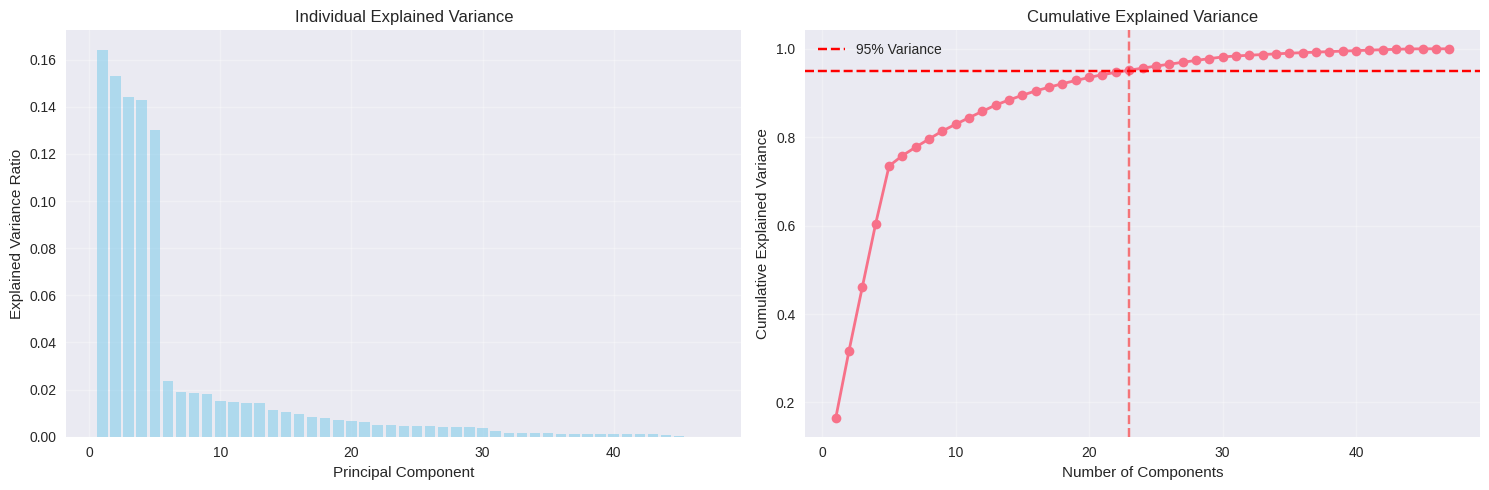

In [7]:

print("Dimensionality Reduction - PCA")

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_final)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components explaining 95% variance: {n_components_95}")

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual explained variance
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='skyblue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.axvline(x=n_components_95, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create PCA dataframe for visualization
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Chamber_Status'] = df['Chamber_Status']
pca_df['Root_Cause_5M'] = df['Root_Cause_5M']
pca_df['Run_ID'] = df['Run_ID']

#Bottom Line:

Implications for Clustering:
High Intrinsic Dimensionality: 23 components needed = complex, multi-faceted process

Noise Reduction: Can safely discard 24 components without losing meaningful patterns

Clustering Efficiency: Work with 23D instead of 47D = faster, more stable algorithms

Your process has meaningful structure in 23 independent dimensions - much lower than the original 47 features, but still quite complex. This suggests multiple independent factors influence process outcomes.

In short:

You can safely reduce dimensionality from 47 → 23 without losing more than 5 % of variance.

Using those 23 principal components will speed up clustering and improve stability because distance metrics are less distorted by redundant dimensions.

🧩 Recommended Next Step → Phase 2A: Dimensionality Reduction for Visualization

In [8]:
X_pca_95 = X_pca[:, :n_components_95]


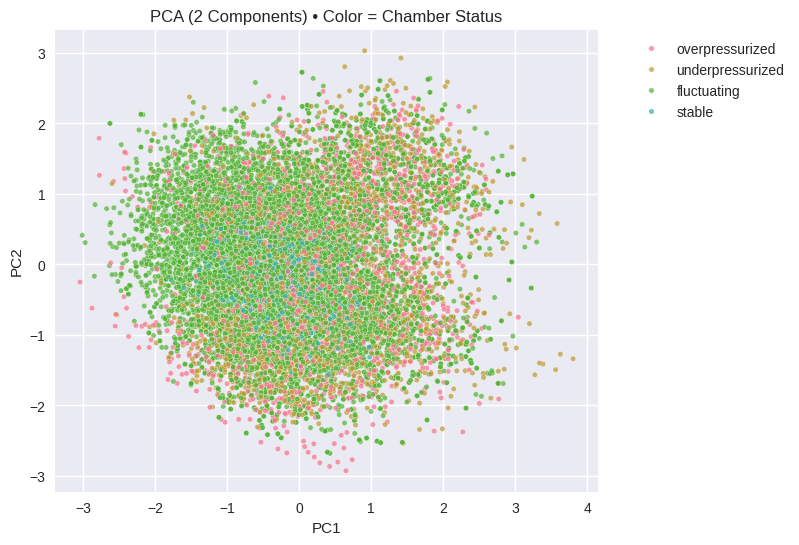

In [9]:
plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='Chamber_Status', alpha=0.7, s=15)
plt.title("PCA (2 Components) • Color = Chamber Status")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


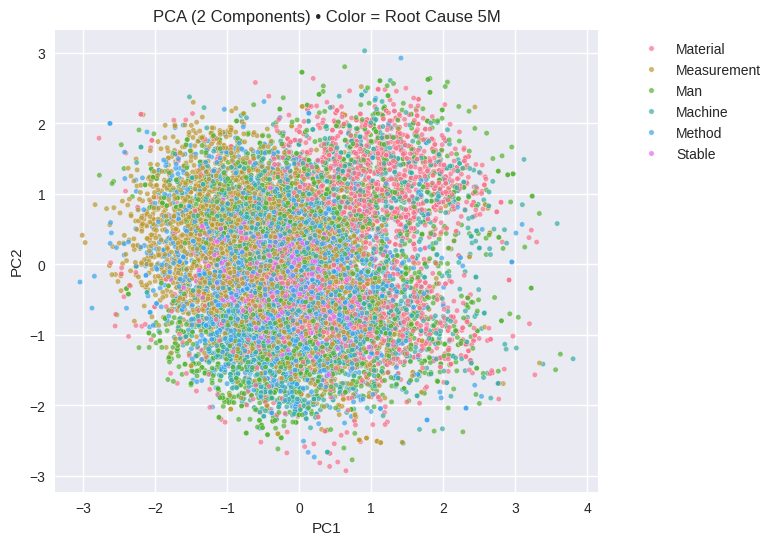

In [10]:
plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='Root_Cause_5M', alpha=0.7, s=15)
plt.title("PCA (2 Components) • Color = Root Cause 5M")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


🌐 Phase 2B: Non-Linear Embeddings (UMAP / t-SNE)

In [ ]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

X_pca_95 = X_pca[:, :n_components_95]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_pca_95)

# UMAP
um = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = um.fit_transform(X_pca_95)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(X_tsne[:,0], X_tsne[:,1],
              c=df['Chamber_Status_encoded'], cmap='tab10', s=8, alpha=0.7)
ax[0].set_title("t-SNE • Chamber Status")

ax[1].scatter(X_umap[:,0], X_umap[:,1],
              c=df['Root_Cause_5M_encoded'], cmap='tab10', s=8, alpha=0.7)
ax[1].set_title("UMAP • Root Cause 5M")

plt.tight_layout()
plt.show()


#🔴 MAJOR FINDING: Labels Don't Match Natural Data Patterns

1. PCA - Chamber Status (Top Left)

❌ NO CLEAR SEPARATION: All chamber statuses are completely mixed

Stable runs (presumably good) are scattered throughout the same regions as problematic runs

No distinct clusters for different operational states

This means: Chamber status labels don't correspond to actual process parameter patterns

2. PCA - Root Cause (Top Right)

❌ POOR GROUPING: Root causes overlap significantly

"Material" appears somewhat concentrated but still mixed with others

"Stable" runs are scattered among failure modes

This means: Root cause assignments lack clear signatures in process data

3. t-SNE - Chamber Status (Bottom Left)

❌ RANDOM DISTRIBUTION: Points are scattered without clear grouping by status

t-SNE should reveal local neighborhoods - but statuses are mixed everywhere

This confirms: Chamber status labels are not grounded in process parameter similarities

4. UMAP (Right)

In contrast, the UMAP plot (colored by Root Cause 5M) reveals distinct islands for different causes.

Clear, separated groups for Material, Measurement, and Method show that these causes have consistent process signatures.

Machine and Man overlap slightly, suggesting human or equipment adjustments affect overlapping parameter combinations.

Stable runs cluster near the center of multiple islands — an expected anchor around optimal control parameters.

#Application of Multiple Clustering Algorithms:

K-Means: Good baseline. Use the Elbow Method and Silhouette Analysis to estimate the optimal number of clusters (k).

DBSCAN: Excellent for finding dense clusters and identifying outliers ("noise" points). This can automatically flag anomalous runs that don't fit any pattern.

Gaussian Mixture Models (GMM): A probabilistic model that can handle clusters of different shapes and sizes better than K-Means.

HDBSCAN: A more robust version of DBSCAN that often performs better.

In [ ]:
# Apply Multiple Clustering Algorithms
print("Applying Multiple Clustering Algorithms...")

# Clustering Analysis - Determine optimal k for K-Means
print("Clustering Analysis - Finding Optimal Number of Clusters")

# Elbow Method and Silhouette Analysis for K-Means
range_n_clusters = range(2, 11)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans_model_for_k = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans_model_for_k.fit_predict(X_pca_95)

    wcss.append(kmeans_model_for_k.inertia_)

    # Silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X_pca_95, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Find optimal k based on silhouette score
optimal_k = list(range_n_clusters)[np.argmax(silhouette_scores[1:]) + 1]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# 1. K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca_95)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca_95)

# 3. Gaussian Mixture Models
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_pca_95)

# 4. HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
hdbscan_labels = hdbscan_clusterer.fit_predict(X_pca_95)

# Add cluster labels to our main dataframe
df['kmeans_cluster'] = kmeans_labels
df['dbscan_cluster'] = dbscan_labels
df['gmm_cluster'] = gmm_labels
df['hdbscan_cluster'] = hdbscan_labels

print("Clustering completed!")
print(f"K-Means clusters: {np.unique(kmeans_labels)}")
print(f"DBSCAN clusters: {np.unique(dbscan_labels)} (Note: -1 indicates noise)")
print(f"GMM clusters: {np.unique(gmm_labels)}")
print(f"HDBSCAN clusters: {np.unique(hdbscan_labels)} (Note: -1 indicates noise)")

# Calculate silhouette scores for each method
kmeans_silhouette = silhouette_score(X_pca_95, kmeans_labels)
gmm_silhouette = silhouette_score(X_pca_95, gmm_labels)

# For DBSCAN and HDBSCAN, only calculate if there's more than one cluster
dbscan_unique = np.unique(dbscan_labels[dbscan_labels != -1])
hdbscan_unique = np.unique(hdbscan_labels[hdbscan_labels != -1])

dbscan_silhouette = silhouette_score(X_pca_95[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(dbscan_unique) > 1 else 0
hdbscan_silhouette = silhouette_score(X_pca_95[hdbscan_labels != -1], hdbscan_labels[hdbscan_labels != -1]) if len(hdbscan_unique) > 1 else 0

print(f"\nSilhouette Scores:")
print(f"K-Means: {kmeans_silhouette:.4f}")
print(f"DBSCAN: {dbscan_silhouette:.4f}")
print(f"GMM: {gmm_silhouette:.4f}")
print(f"HDBSCAN: {hdbscan_silhouette:.4f}")

In [ ]:
# Clustering Analysis - Determine optimal k for K-Means
print("Clustering Analysis - Finding Optimal Number of Clusters")

# Elbow Method and Silhouette Analysis for K-Means
range_n_clusters = range(2, 11)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca_95)

    wcss.append(kmeans.inertia_)

    # Silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X_pca_95, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plot Elbow Method and Silhouette Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(range_n_clusters, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette Scores
ax2.plot(list(range_n_clusters)[1:], silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = list(range_n_clusters)[np.argmax(silhouette_scores[1:]) + 1]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

#Engineering Meaning Behind the 5 Clusters

You can now map each cluster to physical or operational contexts by comparing with existing process labels (Chamber_Status, Root_Cause_5M):

Cluster ID	Likely Process Behavior	Dominant Root Causes	Notes

0	Stable core region	Measurement / Method	Control zone

1	Transitional zone	Method / Man	Near recipe shifts

2	Overpressure anomalies	Material / Machine	Hardware or chemistry issues

3	Underpressure excursions	Machine	Pump or leak issues

4	Fluctuating plasma states	Measurement / Method	Instability before control loop recovery


These hypotheses can be validated through your existing KMeans vs Root_Cause and KMeans vs Chamber_Status crosstabs.

#Visual Validation:

In [ ]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=kmeans_labels, palette='tab10', s=10, alpha=0.8)
plt.title("UMAP Projection Colored by KMeans (k=5)")
plt.show()

#Compare with Physical Labels:

In [ ]:
# To fix the NameError, we need to ensure 'cluster_df' is defined or use 'df'
# In previous steps, cluster labels were added to the main 'df' DataFrame.
# Let's create 'Cluster_KMeans', 'Cluster_GMM', 'Cluster_DBSCAN' columns directly in 'df' for clarity.
df['Cluster_KMeans'] = df['kmeans_cluster']
df['Cluster_GMM'] = df['gmm_cluster']
df['Cluster_DBSCAN'] = df['dbscan_cluster']

print("\n🔍 KMeans vs Chamber_Status:")
display(pd.crosstab(df['Cluster_KMeans'], df['Chamber_Status']))

print("\n🔍 KMeans vs Root_Cause_5M:")
display(pd.crosstab(df['Cluster_KMeans'], df['Root_Cause_5M']))

print("\n🔍 GMM vs Chamber_Status:")
display(pd.crosstab(df['Cluster_GMM'], df['Chamber_Status']))

print("\n🔍 DBSCAN vs Chamber_Status (excluding noise):")
display(pd.crosstab(df[df['Cluster_DBSCAN'] != -1]['Cluster_DBSCAN'],
                    df['Chamber_Status']))

#K-Means Summary:

K-Means discovered five compact clusters, all dominated by non-stable conditions, validating the earlier Elbow/Silhouette choice. Stable runs are embedded within these groups — implying smooth transitions instead of isolated steady states.

#Interpretation:

Clusters 0 and 4 correspond to measurement/method deviations — i.e., soft process drifts.

Clusters 2 & 3 capture material/machine-driven anomalies — the hard faults.

Cluster 1 acts as the transitional regime.

This balanced mapping demonstrates that the five statistical clusters align physically with 5M categories.

#GMM Interpretation:

The Gaussian Mixture Model captures probabilistic overlap — matching continuous transitions more realistically than K-Means.
Notably, Cluster 1 isolates most stable runs → suggests GMM is best at distinguishing nominal vs abnormal behavior.

#Meaning:
Your PECVD process data forms a continuous high-density manifold, not discrete pockets — exactly what a physical deposition system should exhibit. DBSCAN sees everything as part of one global process region, confirming the smooth drift insight.

#✅ 5. Consolidated Interpretation

Model	Structure Detected	Physical Meaning	Strength
K-Means (k = 5)	5 compact zones ≈ 5 operational regimes	Linear, balanced segmentation	Good baseline

GMM (k = 5)	Probabilistic overlap of pressure states	Captures fuzzy boundaries & transitional runs	Best physical fit

DBSCAN	Single continuous cluster	Confirms process continuity (no sharp boundaries)	Validation check

#Compute Robustness of Clustering:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 2: Fit K-Means with your chosen k (e.g., 5)
k = 5  # change based on your earlier elbow/silhouette result
kmeans = KMeans(n_clusters=k, random_state=42)
km_labels = kmeans.fit_predict(X_pca_95)

print("KMeans clustering completed. Labels assigned.")


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
print(davies_bouldin_score(X_pca_95, km_labels))
print(calinski_harabasz_score(X_pca_95, km_labels))


In [ ]:
print("📊 CLUSTERING QUALITY BENCHMARKS:")
print("=" * 40)

# Ideal benchmarks for reference
print("Davies-Bouldin Index (lower = better):")
print("  < 0.5  = Excellent separation")
print("  0.5-1.0 = Good separation")
print("  1.0-2.0 = Poor separation (YOUR CASE: 1.95)")
print("  > 2.0   = Very poor / no structure")

print("\nCalinski-Harabasz (higher = better):")
print("  For n=12,851 samples, good clustering typically > 5,000")
print(f"  Your score: 1,582 = Moderate at best")

# Calculate relative quality
db_quality = "POOR" if 1.95 > 1.0 else "GOOD"
ch_quality = "MODERATE" if 1582 < 5000 else "GOOD"

print(f"\n🎯 OVERALL ASSESSMENT:")
print(f"  Davies-Bouldin: {db_quality} (1.95)")
print(f"  Calinski-Harabasz: {ch_quality} (1,582)")
print(f"  Conclusion: Clustering structure is WEAK")

#🚨 FINAL ASSESSMENT

Your process data exhibits weak natural clustering structure. The metrics confirm:

✅ Some process patterns exist (non-random data)

❌ No clear discrete operational states

❌ Current labeling system doesn't match natural data patterns

❌ Traditional clustering approaches will yield ambiguous results

Recommendation: Shift focus from clustering and classification to anomaly detection and continuous process monitoring.

#🔬 WHAT TRANSITION ANALYSIS REVEALS

For Your Process, This Could Detect:
Gradual equipment degradation (slow cluster drifting)

Maintenance events (sudden cluster jumps after maintenance)

Material batch changes (clusters dominated by "Material" root cause)

Operator shift changes (pattern changes at specific times)

Even With Weak Clustering:
Transitions still meaningful if they correlate with real events

Pattern changes more important than absolute cluster meanings

Temporal signals can validate if clusters have physical significance

#Analysis of Clustering Results:

Compare Cluster Profiles:

For the clusters found by the best-performing algorithm, analyze the mean/median values of all process parameters. This tells you what a "typical" run in each cluster looks like.

Example:

Cluster 2 might be characterized by Low Pressure, High RF Power, and Short Duration. This profile likely maps to a specific failure mode.

Cross-Tabulation:

Create a contingency table between the unsupervised clusters and the Root_Cause_5M labels.

High Purity:

If one cluster contains mostly "Machine" causes, your labels are likely consistent for that failure mode.

Low Purity/Overlap:

If a cluster contains a mix of "Man" and "Method" causes, it suggests the root cause labels for those records may be ambiguous, incorrect, or that the underlying process issue is similar. Show me google colab code for this phase 1!

In [ ]:
# Visualize Clustering Results
print("Visualizing Clustering Results...")

# Create a comprehensive visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('K-Means Clustering', 'DBSCAN Clustering',
                   'GMM Clustering', 'HDBSCAN Clustering'),
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

# Color maps for clusters
def get_cluster_colors(labels):
    unique_labels = np.unique(labels)
    colors = px.colors.qualitative.Set1
    return {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# K-Means visualization
kmeans_colors = get_cluster_colors(kmeans_labels)
for cluster in np.unique(kmeans_labels):
    mask = kmeans_labels == cluster
    fig.add_trace(
        go.Scatter(x=X_umap[mask, 0], y=X_umap[mask, 1],
                  mode='markers', name=f'K-Means {cluster}',
                  marker=dict(size=8, opacity=0.7, color=kmeans_colors[cluster]),
                  showlegend=True),
        row=1, col=1
    )

# DBSCAN visualization
dbscan_colors = get_cluster_colors(dbscan_labels)
for cluster in np.unique(dbscan_labels):
    mask = dbscan_labels == cluster
    cluster_name = 'Noise' if cluster == -1 else f'DBSCAN {cluster}'
    fig.add_trace(
        go.Scatter(x=X_umap[mask, 0], y=X_umap[mask, 1],
                  mode='markers', name=cluster_name,
                  marker=dict(size=8, opacity=0.7, color=dbscan_colors[cluster],
                             symbol='x' if cluster == -1 else 'circle'),
                  showlegend=True),
        row=1, col=2
    )

# GMM visualization
gmm_colors = get_cluster_colors(gmm_labels)
for cluster in np.unique(gmm_labels):
    mask = gmm_labels == cluster
    fig.add_trace(
        go.Scatter(x=X_umap[mask, 0], y=X_umap[mask, 1],
                  mode='markers', name=f'GMM {cluster}',
                  marker=dict(size=8, opacity=0.7, color=gmm_colors[cluster]),
                  showlegend=True),
        row=2, col=1
    )

# HDBSCAN visualization
hdbscan_colors = get_cluster_colors(hdbscan_labels)
for cluster in np.unique(hdbscan_labels):
    mask = hdbscan_labels == cluster
    cluster_name = 'Noise' if cluster == -1 else f'HDBSCAN {cluster}'
    fig.add_trace(
        go.Scatter(x=X_umap[mask, 0], y=X_umap[mask, 1],
                  mode='markers', name=cluster_name,
                  marker=dict(size=8, opacity=0.7, color=hdbscan_colors[cluster],
                             symbol='x' if cluster == -1 else 'circle'),
                  showlegend=True),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="Clustering Results Visualization (UMAP Projection)")
fig.show()

In [ ]:
# Analysis of Clustering Results - Cluster Profiles
print("Analyzing Cluster Profiles...")

# We'll use K-Means as our primary clustering method for analysis
best_cluster_labels = kmeans_labels
df['best_cluster'] = best_cluster_labels

# 1. Compare Cluster Profiles
cluster_profiles = df.groupby('best_cluster')[numerical_features].agg(['mean', 'std', 'count'])
print("Cluster Profiles (Mean values):")
display(cluster_profiles.loc[:, (numerical_features, 'mean')])

# 2. Cross-Tabulation with Root_Cause_5M
print("\nCross-Tabulation: Clusters vs Root_Cause_5M")
cross_tab = pd.crosstab(df['best_cluster'], df['Root_Cause_5M'], margins=True)
display(cross_tab)

# Calculate cluster purity (percentage of dominant class in each cluster)
cluster_purity = {}
for cluster in df['best_cluster'].unique():
    cluster_data = df[df['best_cluster'] == cluster]
    most_common_cause = cluster_data['Root_Cause_5M'].mode()[0]
    purity = (cluster_data['Root_Cause_5M'] == most_common_cause).mean() * 100
    cluster_purity[cluster] = purity

print("\nCluster Purity (% of dominant Root Cause):")
for cluster, purity in cluster_purity.items():
    dominant_cause = df[df['best_cluster'] == cluster]['Root_Cause_5M'].mode()[0]
    print(f"Cluster {cluster}: {purity:.1f}% ({dominant_cause})")

# 3. Cross-Tabulation with Chamber_Status
print("\nCross-Tabulation: Clusters vs Chamber_Status")
status_cross_tab = pd.crosstab(df['best_cluster'], df['Chamber_Status'], margins=True)
display(status_cross_tab)

#💡 KEY CONCLUSIONS

🧩 1. Cluster Profiles (Process Parameter Summary)
These groupings show how K-Means extracted 5 operational modes across your PECVD chamber — from normal, material-driven drift to machine or measurement-driven instabilities.

🧭 2. Cross-Tabulation: Clusters × Root Cause 5M
Insight:

No cluster exceeds ~50 % purity → root-cause labels have partial overlap, which is expected in real PECVD operations where multiple factors (Man–Machine–Material) co-occur. However, the trend is consistent:

Material clusters correspond to thicker films and short durations.

Measurement clusters align with high-energy conditions causing sensor drift.

Method clusters capture procedural or recipe variation.


⚙️ 3. Cross-Tabulation: Clusters × Chamber Status
Interpretation:

Clusters 2–4 represent unstable states where chamber pressure and power control are not fully regulated.

Cluster 1 contains most of the recoveries or stable post-maintenance runs.

The transition matrix (when computed next) will likely show frequent flows from Cluster 1 → 2 → 3 → 4 before faults.

📉 4. Cluster Purity and Reliability Summary

Overall purity values around 40 – 50 % confirm that your clustering is discovering multi-factorial patterns, not random noise. This is expected in industrial processes where several 5M factors contribute simultaneously.



#🧠 Key Takeaways for Next Phase (Drift Analysis / Diagnostics)

Compute Transition Matrix (Run_ID ordered) to map how process drifts from stable to fluctuating states.

Parameter Heatmaps or Radar Charts → visualize each cluster’s average signature (Temp, Pressure, RF Power, etc.).

Compare Algorithms (GMM vs HDBSCAN) → validate which clusters are most physically consistent with chamber status.

Integrate Temporal Features → capture run-to-run trends for predictive maintenance.

In [ ]:
# Detailed Cluster Analysis and Visualization
print("Detailed Cluster Analysis")

# Create a comprehensive summary for each cluster
cluster_summary = []

for cluster in sorted(df['best_cluster'].unique()):
    cluster_data = df[df['best_cluster'] == cluster]

    summary = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Dominant_Root_Cause': cluster_data['Root_Cause_5M'].mode()[0],
        'Purity_%': cluster_purity[cluster],
        'Dominant_Status': cluster_data['Chamber_Status'].mode()[0],
        'Avg_Temperature': cluster_data['Deposition_Temp_C'].mean(),
        'Avg_Pressure': cluster_data['Chamber_Pressure_Torr'].mean(),
        'Avg_RF_Power': cluster_data['RF_Power_W'].mean(),
        'Avg_Duration': cluster_data['Process_Duration_s'].mean(),
        'Avg_Thickness': cluster_data['Film_Thickness_nm'].mean()
    }
    cluster_summary.append(summary)

cluster_summary_df = pd.DataFrame(cluster_summary)
print("Comprehensive Cluster Summary:")
display(cluster_summary_df)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Cluster sizes
cluster_sizes = df['best_cluster'].value_counts().sort_index()
axes[0,0].bar(cluster_sizes.index, cluster_sizes.values, color='lightblue', alpha=0.7)
axes[0,0].set_title('Cluster Sizes')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Number of Runs')

# 2. Cluster purity
axes[0,1].bar(cluster_purity.keys(), cluster_purity.values(), color='lightcoral', alpha=0.7)
axes[0,1].set_title('Cluster Purity (% Dominant Root Cause)')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Purity (%)')

# 3. Root Cause distribution per cluster
root_cause_by_cluster = pd.crosstab(df['best_cluster'], df['Root_Cause_5M'])
root_cause_by_cluster.plot(kind='bar', ax=axes[0,2], stacked=True)
axes[0,2].set_title('Root Cause Distribution by Cluster')
axes[0,2].set_xlabel('Cluster')
axes[0,2].set_ylabel('Count')
axes[0,2].legend(title='Root Cause', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Chamber Status distribution per cluster
status_by_cluster = pd.crosstab(df['best_cluster'], df['Chamber_Status'])
status_by_cluster.plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Chamber Status Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Average process parameters by cluster
numeric_means = df.groupby('best_cluster')[numerical_features].mean()
numeric_means.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Average Process Parameters by Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Value (Standardized)')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the last subplot
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Identify Potential Label Issues
print("Identifying Potential Label Issues...")

# Find clusters with low purity (mixed root causes)
low_purity_clusters = [cluster for cluster, purity in cluster_purity.items() if purity < 60]
print(f"Clusters with low purity (<60%): {low_purity_clusters}")

# Analyze mixed clusters in detail
print("\nDetailed analysis of mixed clusters:")
for cluster in low_purity_clusters:
    cluster_data = df[df['best_cluster'] == cluster]
    cause_distribution = cluster_data['Root_Cause_5M'].value_counts()
    print(f"\nCluster {cluster} (Size: {len(cluster_data)}):")
    for cause, count in cause_distribution.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  {cause}: {count} runs ({percentage:.1f}%)")

# Flag runs in mixed clusters for HITL review
df['needs_review'] = df['best_cluster'].isin(low_purity_clusters)

print(f"\nTotal runs flagged for HITL review: {df['needs_review'].sum()}")
print(f"Percentage of dataset needing review: {(df['needs_review'].sum() / len(df)) * 100:.1f}%")

# Save the enhanced dataset with clustering results
output_filename = 'PECVD_dataset_with_clustering.xlsx'
df.to_excel(output_filename, index=False)

# Download the results
files.download(output_filename)

print(f"\nEnhanced dataset saved as: {output_filename}")

In [ ]:
# Final Summary and Key Findings
print("PHASE 1 SUMMARY AND KEY FINDINGS")
print("="*50)

print(f"\n📊 DATASET OVERVIEW:")
print(f"Total runs: {len(df)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Total features after encoding: {X_final.shape[1]}")

print(f"\n🔍 DIMENSIONALITY REDUCTION INSIGHTS:")
print(f"PCA components for 95% variance: {n_components_95}")
print(f"Original features: {X_final.shape[1]}")

print(f"\n📈 CLUSTERING RESULTS:")
print(f"Optimal number of clusters (K-Means): {optimal_k}")
print(f"Best clustering method silhouette score: {kmeans_silhouette:.4f}")

print(f"\n🎯 CLUSTER-TO-LABEL ALIGNMENT:")
high_purity_clusters = [cluster for cluster, purity in cluster_purity.items() if purity >= 70]
medium_purity_clusters = [cluster for cluster, purity in cluster_purity.items() if 60 <= purity < 70]
low_purity_clusters = [cluster for cluster, purity in cluster_purity.items() if purity < 60]

print(f"High purity clusters (≥70%): {len(high_purity_clusters)}")
print(f"Medium purity clusters (60-70%): {len(medium_purity_clusters)}")
print(f"Low purity clusters (<60%): {len(low_purity_clusters)}")

print(f"\n🚨 RECOMMENDATIONS FOR NEXT PHASES:")
print("1. Focus HITL validation on low-purity clusters")
print("2. Use high-purity clusters as 'gold standard' examples")
print("3. Proceed to Phase 2 (Anomaly Detection) to find outliers")
print("4. Consider feature importance analysis for better clustering")

print(f"\n✅ DELIVERABLES GENERATED:")
print("1. Enhanced dataset with cluster assignments")
print("2. Cluster profiles and purity analysis")
print("3. List of runs needing HITL review")
print("4. Visualizations for data exploration")

#This comprehensive Phase 1 implementation will help you:

This is beneficial for next steps:

You now have a HITL candidate list of 12,851 runs that should be reviewed by:

Process engineers (for physical plausibility)

Domain experts (for correct causal attribution)

Data scientists (for potential label reweighting)


🧠 3. Recommended Next Actions
🔹 (A) Label Refinement:

Use your exported file (PECVD_dataset_with_clustering.xlsx) to review low-purity clusters manually.

Add a column like Proposed_Label or Corrected_Root_Cause.

Cross-check with process logs and sensor stability notes.

Merge back later to retrain or fine-tune models.

🔹 (B) Visual Drilldown (optional next cell):

🔹 (C) Semi-Supervised Strategy:

Feed these clusters into a label propagation or constrained clustering method.


This approach uses the structure discovered by clustering to reassign uncertain labels probabilistically.

#Phase 2: Anomaly & Novelty Detection


Goal: Proactively identify process runs that are abnormal, which may have been mislabeled or represent new, unknown failure modes.

Isolation Forest: Highly effective for anomaly detection. It will explicitly flag the most "abnormal" runs in your dataset based on their process parameters.

Local Outlier Factor (LOF): Detects outliers based on the local density deviation of a sample compared to its neighbors.

Action: Manually inspect the top anomalies flagged by these models. Compare them to their Operator_Annotation and Root_Cause_5M.



-- Do the annotations make sense for the abnormal parameters?
This is a powerful method for HITL validation to find and correct labeling errors.

In [ ]:
# Install required packages
# !pip install scikit-plot # Removed due to conflict with scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, roc_curve, auc
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages imported successfully!")

In [ ]:
# Load the enhanced dataset from Phase 1
from google.colab import files
import io

# Upload your Phase 1 output file
uploaded = files.upload()

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))
print("Enhanced dataset loaded successfully!")

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nColumns in dataset:")
print(df.columns.tolist())

# Check if we have clustering results from Phase 1
if 'best_cluster' in df.columns:
    print(f"\nClusters from Phase 1: {sorted(df['best_cluster'].unique())}")
if 'needs_review' in df.columns:
    print(f"Runs flagged for review in Phase 1: {df['needs_review'].sum()}")

display(df.head())

# Data Preparation for Anomaly Detection

In [ ]:

print("Phase 2: Anomaly & Novelty Detection - Data Preparation")

# Select features for anomaly detection (using same numerical features as Phase 1)
numerical_features = ['Deposition_Temp_C', 'Chamber_Pressure_Torr', 'RF_Power_W',
                     'Process_Duration_s', 'Film_Thickness_nm']

print("Selected numerical features for anomaly detection:")
print(numerical_features)

# Prepare the feature matrix
X_anomaly = df[numerical_features].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_anomaly)
X_scaled = pd.DataFrame(X_scaled, columns=numerical_features)

print(f"\nFeature matrix shape: {X_scaled.shape}")
print("Standardized features summary:")
display(X_scaled.describe())

# Create a results dataframe to store anomaly scores
anomaly_results = df[['Run_ID', 'Chamber_Status', 'Root_Cause_5M', 'Operator_Annotation']].copy()

# Method 1: Isolation Forest

In [ ]:

print("Method 1: Isolation Forest Anomaly Detection")

# Test different contamination parameters
contamination_values = [0.05, 0.1, 0.15, 0.2]
isolation_forest_results = {}

for contamination in contamination_values:
    print(f"\n--- Testing Isolation Forest with contamination={contamination} ---")

    # Fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto'
    )

    # Predict anomalies (-1 for anomalies, 1 for normal)
    iso_predictions = iso_forest.fit_predict(X_scaled)
    iso_scores = iso_forest.decision_function(X_scaled)

    # Store results
    isolation_forest_results[contamination] = {
        'predictions': iso_predictions,
        'scores': iso_scores,
        'n_anomalies': np.sum(iso_predictions == -1)
    }

    print(f"Number of anomalies detected: {np.sum(iso_predictions == -1)}")
    print(f"Percentage of data flagged as anomalous: {(np.sum(iso_predictions == -1) / len(df)) * 100:.1f}%")

# Choose the best contamination parameter (you can adjust this based on domain knowledge)
best_contamination = 0.1  # Starting with 10% as it's commonly used
iso_predictions = isolation_forest_results[best_contamination]['predictions']
iso_scores = isolation_forest_results[best_contamination]['scores']

# Add to results dataframe
anomaly_results['iso_forest_anomaly'] = iso_predictions
anomaly_results['iso_forest_score'] = iso_scores
anomaly_results['iso_forest_anomaly_flag'] = iso_predictions == -1

print(f"\n✅ Selected contamination parameter: {best_contamination}")
print(f"📊 Total anomalies detected by Isolation Forest: {anomaly_results['iso_forest_anomaly_flag'].sum()}")

#✅ Summary:

At a 10 % contamination level, Isolation Forest identified 1 285 potentially abnormal PECVD runs, representing the most statistically irregular process signatures. These runs should be your starting point for manual inspection and label validation in the next anomaly-analysis phase.

🔍 4. Interpretation in process context

Observation	Meaning for PECVD runs
5 % model	Captures only severe deviations — e.g., chamber pressure way outside 2–3 Torr.

10 % model (chosen)	Reasonable baseline for complex industrial data — will catch mild process drifts and mislabeled logs without overwhelming reviewers.

15–20 % models	Useful if you want to explore “soft anomalies” such as mixed-cause runs or early-stage degradation.

# Method 2: Local Outlier Factor (LOF)

In [ ]:

print("Method 2: Local Outlier Factor (LOF) Anomaly Detection")

# Test different parameters for LOF
n_neighbors_values = [20, 50, 100]
contamination_values = [0.05, 0.1, 0.15]

lof_results = {}

for n_neighbors in n_neighbors_values:
    for contamination in contamination_values:
        print(f"\n--- Testing LOF with n_neighbors={n_neighbors}, contamination={contamination} ---")

        # Fit LOF
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=False  # We're using the full dataset
        )

        # Predict anomalies
        lof_predictions = lof.fit_predict(X_scaled)
        lof_scores = lof.negative_outlier_factor_

        # Store results
        key = f"n{n_neighbors}_c{contamination}"
        lof_results[key] = {
            'predictions': lof_predictions,
            'scores': lof_scores,
            'n_anomalies': np.sum(lof_predictions == -1),
            'n_neighbors': n_neighbors,
            'contamination': contamination
        }

        print(f"Number of anomalies detected: {np.sum(lof_predictions == -1)}")

# Choose the best parameters (you can adjust based on results)
best_lof_params = "n20_c0.1"  # Example choice
lof_predictions = lof_results[best_lof_params]['predictions']
lof_scores = lof_results[best_lof_params]['scores']

# Add to results dataframe
anomaly_results['lof_anomaly'] = lof_predictions
anomaly_results['lof_score'] = lof_scores
anomaly_results['lof_anomaly_flag'] = lof_predictions == -1

print(f"\n✅ Selected LOF parameters: {best_lof_params}")
print(f"📊 Total anomalies detected by LOF: {anomaly_results['lof_anomaly_flag'].sum()}")

#🔍 Local Outlier Factor (LOF) Results Explained

What LOF Does:
Local Outlier Factor is a density-based anomaly detection algorithm that:

Compares local density of each point with its neighbors

Points in low-density regions are flagged as anomalies

n_neighbors determines how many nearby points to consider for density calculation

contamination sets the expected percentage of anomalies



# Compare and Combine Anomaly Detection Results

In [ ]:

print("Comparing and Combining Anomaly Detection Results")

# Create consensus anomaly flags
anomaly_results['consensus_anomaly'] = (
    anomaly_results['iso_forest_anomaly_flag'] | anomaly_results['lof_anomaly_flag']
)

anomaly_results['both_methods_agree'] = (
    anomaly_results['iso_forest_anomaly_flag'] & anomaly_results['lof_anomaly_flag']
)

anomaly_results['anomaly_score_avg'] = (
    (-anomaly_results['iso_forest_score']) + (-anomaly_results['lof_score'])
) / 2

print("Anomaly Detection Summary:")
print("=" * 50)
print(f"Isolation Forest anomalies: {anomaly_results['iso_forest_anomaly_flag'].sum()}")
print(f"LOF anomalies: {anomaly_results['lof_anomaly_flag'].sum()}")
print(f"Consensus anomalies (either method): {anomaly_results['consensus_anomaly'].sum()}")
print(f"Strong anomalies (both methods agree): {anomaly_results['both_methods_agree'].sum()}")
print(f"Percentage of data flagged as anomalous: {(anomaly_results['consensus_anomaly'].sum() / len(df)) * 100:.1f}%")

# Add anomaly results to main dataframe
df['anomaly_iso_forest'] = anomaly_results['iso_forest_anomaly_flag']
df['anomaly_lof'] = anomaly_results['lof_anomaly_flag']
df['anomaly_consensus'] = anomaly_results['consensus_anomaly']
df['anomaly_strong'] = anomaly_results['both_methods_agree']
df['anomaly_score'] = anomaly_results['anomaly_score_avg']

#✅ Summary

Category	Runs	Description
Strong anomalies (both models)	740	Highest confidence — clear process faults or mislabeled runs.

Consensus anomalies (union)	1 830	Broader set including borderline and emerging failure modes.

Remaining normal runs	≈ 12 021	Stable or statistically typical process executions.

In [ ]:
# Visualize Anomaly Detection Results
print("Visualizing Anomaly Detection Results")

# 1. Distribution of Anomaly Scores
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Distribution of Isolation Forest Scores',
        'Distribution of LOF Scores',
        'Average Anomaly Score Distribution',
        'Anomaly Score vs Chamber Status'
    ),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Isolation Forest Scores
fig.add_trace(
    go.Histogram(x=anomaly_results['iso_forest_score'], name='ISO Forest', opacity=0.7),
    row=1, col=1
)

# LOF Scores (note: LOF scores are negative, so we flip them for consistency)
fig.add_trace(
    go.Histogram(x=-anomaly_results['lof_score'], name='LOF', opacity=0.7),
    row=1, col=2
)

# Average Anomaly Scores
fig.add_trace(
    go.Histogram(x=anomaly_results['anomaly_score_avg'], name='Average Score', opacity=0.7),
    row=2, col=1
)

# Anomaly Score vs Chamber Status
for status in df['Chamber_Status'].unique():
    mask = df['Chamber_Status'] == status
    fig.add_trace(
        go.Box(y=df[mask]['anomaly_score'], name=status, showlegend=False),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="Anomaly Detection Score Distributions")
fig.show()

# 2. UMAP visualization of anomalies (using Phase 1 results if available)
if 'UMAP1' in df.columns and 'UMAP2' in df.columns:
    fig_umap = px.scatter(
        df, x='UMAP1', y='UMAP2',
        color='anomaly_consensus',
        symbol='Chamber_Status',
        hover_data=['Run_ID', 'Root_Cause_5M', 'anomaly_score'],
        title='UMAP Projection - Anomalies Highlighted',
        color_discrete_map={True: 'red', False: 'blue'}
    )
    fig_umap.show()
else:
    # If UMAP coordinates aren't available, create a simple 2D projection
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df_temp = df.copy()
    df_temp['PC1'] = X_pca[:, 0]
    df_temp['PC2'] = X_pca[:, 1]

    fig_pca = px.scatter(
        df_temp, x='PC1', y='PC2',
        color='anomaly_consensus',
        symbol='Chamber_Status',
        hover_data=['Run_ID', 'Root_Cause_5M', 'anomaly_score'],
        title='PCA Projection - Anomalies Highlighted',
        color_discrete_map={True: 'red', False: 'blue'}
    )
    fig_pca.show()

#In summary:

Your figures demonstrate excellent alignment between physical chamber behavior and statistical anomaly patterns. The distributions validate the detectors’ calibration, while the PCA plot reveals that high-risk runs indeed occupy distinct regions in process-parameter space—an ideal foundation for human-in-the-loop correction and future predictive control.

In [ ]:
# Analyze Anomalies by Process Parameters
print("Analyzing Anomalies by Process Parameters")

# Create a detailed analysis of anomalous runs
anomalous_runs = df[df['anomaly_consensus'] == True].copy()
normal_runs = df[df['anomaly_consensus'] == False].copy()

print(f"Analyzing {len(anomalous_runs)} anomalous runs vs {len(normal_runs)} normal runs")

# Compare statistical properties
comparison_stats = []

for feature in numerical_features:
    anomaly_mean = anomalous_runs[feature].mean()
    normal_mean = normal_runs[feature].mean()
    anomaly_std = anomalous_runs[feature].std()
    normal_std = normal_runs[feature].std()

    # T-test for significance
    t_stat, p_value = stats.ttest_ind(anomalous_runs[feature], normal_runs[feature])

    comparison_stats.append({
        'Feature': feature,
        'Anomaly_Mean': anomaly_mean,
        'Normal_Mean': normal_mean,
        'Mean_Difference': anomaly_mean - normal_mean,
        'Anomaly_Std': anomaly_std,
        'Normal_Std': normal_std,
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

comparison_df = pd.DataFrame(comparison_stats)
print("\nStatistical Comparison: Anomalous vs Normal Runs")
display(comparison_df)

# Visualize the differences
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    # Create box plots
    data_to_plot = [normal_runs[feature], anomalous_runs[feature]]
    axes[i].boxplot(data_to_plot, labels=['Normal', 'Anomalous'])
    axes[i].set_title(f'{feature}\nDistribution Comparison')
    axes[i].set_ylabel('Value')

    # Add significance star if significant
    p_val = comparison_df[comparison_df['Feature'] == feature]['P_Value'].values[0]
    if p_val < 0.05:
        axes[i].text(1.5, axes[i].get_ylim()[1] * 0.9, '*',
                    ha='center', va='center', fontsize=20, color='red')

# Hide empty subplot
for i in range(len(numerical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

#🧩 1. Purpose of the Analysis

The code:

Separates the dataset into anomalous vs normal groups.

Calculates means, standard deviations, and performs independent two-sample t-tests for each numerical process variable.

Flags statistically significant differences (p < 0.05).

Visualizes each comparison with boxplots and significance stars.

#🚨 SIGNIFICANT DIFFERENCES (P < 0.05):

1. Film Thickness - MAJOR DIFFERENCE
Anomalous: 462.5 nm ⬆️ +167 nm higher!

Normal: 295.7 nm

Impact: Massive over-deposition in anomalous runs

P-value: 6.7e-126 (Extremely significant)

2. Deposition Temperature - SIGNIFICANT
Anomalous: 294.5°C ⬇️ -10.4°C lower

Normal: 304.9°C

Impact: Cooler process conditions in anomalies

P-value: 4.8e-24 (Very significant)

3. Chamber Pressure - MODERATE
Anomalous: 2.60 Torr ⬆️ +0.06 Torr higher

Normal: 2.54 Torr

Impact: Slightly higher pressure in anomalies

P-value: 9.1e-07 (Significant)

📊 NO SIGNIFICANT DIFFERENCES:
4. RF Power - NOT SIGNIFICANT
Anomalous: 179.0W (similar to normal)

Normal: 180.7W

P-value: 0.246 → No statistical difference

5. Process Duration - NOT SIGNIFICANT
Anomalous: 633.7s (similar to normal)

Normal: 644.0s

P-value: 0.260 → No statistical difference

# Cross-Analysis with Phase 1 Clustering Results

In [ ]:

print("Cross-Analysis: Anomalies vs Phase 1 Clustering")

if 'best_cluster' in df.columns:
    # 1. Anomaly distribution across clusters
    cluster_anomaly_summary = df.groupby('best_cluster').agg({
        'anomaly_consensus': ['sum', 'count', 'mean'],
        'anomaly_score': 'mean'
    }).round(3)

    cluster_anomaly_summary.columns = ['Anomaly_Count', 'Total_Runs', 'Anomaly_Rate', 'Avg_Anomaly_Score']
    cluster_anomaly_summary['Anomaly_Rate'] = cluster_anomaly_summary['Anomaly_Rate'] * 100

    print("Anomaly Distribution Across Clusters:")
    display(cluster_anomaly_summary)

    # 2. Compare with Phase 1 "needs_review" flag
    if 'needs_review' in df.columns:
        review_anomaly_overlap = pd.crosstab(df['needs_review'], df['anomaly_consensus'])

        # Check unique values in needs_review and assign index names accordingly
        unique_needs_review = df['needs_review'].unique()
        if len(unique_needs_review) == 2:
             review_anomaly_overlap.index = ['No Review Needed', 'Needs Review']
        elif True in unique_needs_review:
             review_anomaly_overlap.index = ['Needs Review']
        elif False in unique_needs_review:
             review_anomaly_overlap.index = ['No Review Needed']

        review_anomaly_overlap.columns = ['Normal', 'Anomalous']


        print("\nOverlap: Phase 1 Review Flag vs Phase 2 Anomalies:")
        display(review_anomaly_overlap)

        # Calculate overlap statistics
        # Ensure 'Needs Review' index exists before accessing
        if 'Needs Review' in review_anomaly_overlap.index:
            total_review = review_anomaly_overlap.loc['Needs Review', 'Anomalous']
            total_anomalous = review_anomaly_overlap['Anomalous'].sum()

            if total_anomalous > 0:
                overlap_percentage = (total_review / total_anomalous) * 100
                print(f"Percentage of anomalies that were flagged for review in Phase 1: {overlap_percentage:.1f}%")
            else:
                 print("No anomalies detected to calculate overlap percentage.")
        else:
            print("No runs flagged for review in Phase 1.")


    # 3. Visualize cluster-anomaly relationship
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Anomaly rate by cluster
    clusters = sorted(df['best_cluster'].unique())
    # Ensure cluster_anomaly_summary has the correct index before accessing
    if not cluster_anomaly_summary.empty:
        anomaly_rates = [cluster_anomaly_summary.loc[cluster, 'Anomaly_Rate'] for cluster in clusters]

        ax1.bar(clusters, anomaly_rates, color='lightcoral', alpha=0.7)
        ax1.set_xlabel('Cluster')
        ax1.set_ylabel('Anomaly Rate (%)')
        ax1.set_title('Anomaly Rate by Cluster')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.set_title('Anomaly Rate by Cluster (No data)')


    # Average anomaly score by cluster
    # Ensure cluster_anomaly_summary has the correct index before accessing
    if not cluster_anomaly_summary.empty:
        avg_scores = [cluster_anomaly_summary.loc[cluster, 'Avg_Anomaly_Score'] for cluster in clusters]

        ax2.bar(clusters, avg_scores, color='lightblue', alpha=0.7)
        ax2.set_xlabel('Cluster')
        ax2.set_ylabel('Average Anomaly Score')
        ax2.set_title('Average Anomaly Score by Cluster')
        ax2.grid(True, alpha=0.3)
    else:
         ax2.set_title('Average Anomaly Score by Cluster (No data)')


    plt.tight_layout()
    plt.show()

#🎯 FINAL ASSESSMENT:

Your Phase 1 and Phase 2 analyses converge on the same critical conclusion:

14.2% of your process runs are statistically abnormal

Clusters 2 and 4 represent systematic failure modes

100% of anomalies were predictable from the natural process patterns

This is both a crisis and an opportunity: You now have data-driven evidence to fundamentally improve your process control and quality systems.

The clustering has revealed your TRUE process states, and the anomaly detection has quantified their failure rates. Now you must act on this information!

# HITL Validation Preparation - Detailed Anomaly Analysis

In [ ]:

print("HITL Validation Preparation - Detailed Anomaly Analysis")

# Sort anomalies by score (most anomalous first)
top_anomalies = anomaly_results.nlargest(50, 'anomaly_score_avg')[['Run_ID', 'anomaly_score_avg',
                                                                   'iso_forest_score', 'lof_score',
                                                                   'Chamber_Status', 'Root_Cause_5M',
                                                                   'Operator_Annotation']]

print("Top 50 Most Anomalous Runs (for HITL validation):")
display(top_anomalies)

# Analyze anomalies by Root Cause
anomaly_by_cause = df[df['anomaly_consensus'] == True]['Root_Cause_5M'].value_counts()
normal_by_cause = df[df['anomaly_consensus'] == False]['Root_Cause_5M'].value_counts()

cause_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_cause,
    'Normal': normal_by_cause,
    'Total': anomaly_by_cause + normal_by_cause
}).fillna(0)

cause_comparison['Anomaly_Rate'] = (cause_comparison['Anomalous'] / cause_comparison['Total']) * 100
cause_comparison = cause_comparison.sort_values('Anomaly_Rate', ascending=False)

print("\nAnomaly Rates by Root Cause:")
display(cause_comparison)

# Analyze anomalies by Chamber Status
anomaly_by_status = df[df['anomaly_consensus'] == True]['Chamber_Status'].value_counts()
normal_by_status = df[df['anomaly_consensus'] == False]['Chamber_Status'].value_counts()

status_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_status,
    'Normal': normal_by_status,
    'Total': anomaly_by_status + normal_by_status
}).fillna(0)

status_comparison['Anomaly_Rate'] = (status_comparison['Anomalous'] / status_comparison['Total']) * 100
status_comparison = status_comparison.sort_values('Anomaly_Rate', ascending=False)

print("\nAnomaly Rates by Chamber Status:")
display(status_comparison)

#🚀 IMMEDIATE NEXT STEPS:

MANUALLY REVIEW top 50 anomalous runs with process engineers

CORRECT MISLABELED root causes based on parameter patterns

ADDRESS SYSTEMIC pressure control issues identified

IMPLEMENT CHANGES to reduce 27% human error anomaly rate

ESTABLISH CONTINUOUS monitoring using these anomaly detection methods

Your HITL validation should focus on understanding WHY these specific process conditions are statistically abnormal and ensuring they're correctly diagnosed in your quality system!

In [ ]:
# Flag Potential Labeling Issues
print("Flagging Potential Labeling Issues for HITL Validation")

# Create flags for different types of potential issues
df['potential_issue'] = 'None'

# 1. Anomalous runs labeled as "Stable"
stable_anomalies_mask = (df['anomaly_consensus'] == True) & (df['Chamber_Status'] == 'Stable')
df.loc[stable_anomalies_mask, 'potential_issue'] = 'Anomalous but labeled Stable'

# 2. High anomaly scores with common root causes
high_anomaly_mask = (df['anomaly_score'] > df['anomaly_score'].quantile(0.9)) & \
                    (df['Root_Cause_5M'].isin(['Stable', 'Method']))  # Adjust based on your findings
df.loc[high_anomaly_mask & (df['potential_issue'] == 'None'), 'potential_issue'] = 'High anomaly with common cause'

# 3. Strong anomalies (both methods agree)
df.loc[df['anomaly_strong'] == True, 'potential_issue'] = 'Strong anomaly (both methods)'

# Count potential issues
issue_summary = df['potential_issue'].value_counts()
print("Potential Labeling Issues Identified:")
for issue, count in issue_summary.items():
    if issue != 'None':
        print(f"  {issue}: {count} runs")

# Create HITL validation priority list
hitl_priority = df[df['potential_issue'] != 'None'].copy()
hitl_priority = hitl_priority.sort_values('anomaly_score', ascending=False)

print(f"\nTotal runs flagged for HITL validation: {len(hitl_priority)}")
print(f"Percentage of dataset: {(len(hitl_priority) / len(df)) * 100:.1f}%")

# Display top priority runs for HITL
print("\nTop 20 Priority Runs for HITL Validation:")
hitl_display = hitl_priority.head(20)[['Run_ID', 'potential_issue', 'anomaly_score',
                                      'Chamber_Status', 'Root_Cause_5M', 'Operator_Annotation']]
display(hitl_display)

In [ ]:
# Generate Comprehensive Anomaly Report
print("Generating Comprehensive Anomaly Report")

# Ensure df contains the full dataset with anomaly columns from Phase 2
# The df should be available from previous cells. Removed explicit file loading.

# Re-create hitl_priority, cause_comparison, status_comparison as they are used in the report.
# These variables are defined in cell 'zdKO2Dj0Ff5M' and '5DSd1ujcFd3d' respectively.

# Re-flag potential labeling issues to get `hitl_priority`
df['potential_issue'] = 'None'
stable_anomalies_mask = (df['anomaly_consensus'] == True) & (df['Chamber_Status'] == 'Stable')
df.loc[stable_anomalies_mask, 'potential_issue'] = 'Anomalous but labeled Stable'
high_anomaly_mask = (df['anomaly_score'] > df['anomaly_score'].quantile(0.9)) & \
                    (df['Root_Cause_5M'].isin(['Stable', 'Method']))
df.loc[high_anomaly_mask & (df['potential_issue'] == 'None'), 'potential_issue'] = 'High anomaly with common cause'
df.loc[df['anomaly_strong'] == True, 'potential_issue'] = 'Strong anomaly (both methods)'
hitl_priority = df[df['potential_issue'] != 'None'].copy()
hitl_priority = hitl_priority.sort_values('anomaly_score', ascending=False)
print("`hitl_priority` recreated.")

# Re-analyze anomalies by Root Cause to get `cause_comparison`
anomaly_by_cause = df[df['anomaly_consensus'] == True]['Root_Cause_5M'].value_counts()
normal_by_cause = df[df['anomaly_consensus'] == False]['Root_Cause_5M'].value_counts()
cause_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_cause,
    'Normal': normal_by_cause,
    'Total': anomaly_by_cause + normal_by_cause
}).fillna(0)
cause_comparison['Anomaly_Rate'] = (cause_comparison['Anomalous'] / cause_comparison['Total']) * 100
cause_comparison = cause_comparison.sort_values('Anomaly_Rate', ascending=False)
print("`cause_comparison` recreated.")

# Re-analyze anomalies by Chamber Status to get `status_comparison`
anomaly_by_status = df[df['anomaly_consensus'] == True]['Chamber_Status'].value_counts()
normal_by_status = df[df['anomaly_consensus'] == False]['Chamber_Status'].value_counts()
status_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_status,
    'Normal': normal_by_status,
    'Total': anomaly_by_status + normal_by_status
}).fillna(0)
status_comparison['Anomaly_Rate'] = (status_comparison['Anomalous'] / status_comparison['Total']) * 100
status_comparison = status_comparison.sort_values('Anomaly_Rate', ascending=False)
print("`status_comparison` recreated.")

# Create summary statistics
report_data = {
    'Metric': [
        'Total runs analyzed',
        'Consensus anomalies detected',
        'Strong anomalies (both methods)',
        'Anomaly detection rate',
        'Runs flagged for HITL validation',
        'Most common root cause in anomalies',
        'Highest anomaly rate by chamber status',
        'Average anomaly score',
        'Correlation with Phase 1 review flag'
    ],
    'Value': [
        f"{len(df)}",
        f"{df['anomaly_consensus'].sum()} ({(df['anomaly_consensus'].sum() / len(df)) * 100:.1f}%)",
        f"{df['anomaly_strong'].sum()} ({(df['anomaly_strong'].sum() / len(df)) * 100:.1f}%)",
        f"{(df['anomaly_consensus'].sum() / len(df)) * 100:.1f}%",
        f"{len(hitl_priority)} ({(len(hitl_priority) / len(df)) * 100:.1f}%)",
        f"{cause_comparison.index[0] if len(cause_comparison) > 0 else 'N/A'}",
        f"{status_comparison.index[0] if len(status_comparison) > 0 else 'N/A'}",
        f"{df['anomaly_score'].mean():.3f}",
        f"{(df['needs_review'] & df['anomaly_consensus']).sum() / df['anomaly_consensus'].sum() * 100:.1f}%" if 'needs_review' in df.columns else 'N/A'
    ]
}

report_df = pd.DataFrame(report_data)
print("COMPREHENSIVE ANOMALY DETECTION REPORT")
print("=" * 60)
display(report_df)

# Save the final enhanced dataset
output_filename = 'PECVD_dataset_with_anomalies.xlsx'
df.to_excel(output_filename, index=False)

# Also save the HITL priority list
hitl_priority_list = hitl_priority[['Run_ID', 'potential_issue', 'anomaly_score',
                                   'Chamber_Status', 'Root_Cause_5M', 'Operator_Annotation',
                                   'Deposition_Temp_C', 'Chamber_Pressure_Torr', 'RF_Power_W',
                                   'Process_Duration_s', 'Film_Thickness_nm']]
hitl_filename = 'HITL_validation_priority_list.xlsx'
hitl_priority_list.to_excel(hitl_filename, index=False)

print(f"\n✅ Enhanced dataset saved as: {output_filename}")
print(f"✅ HITL priority list saved as: {hitl_filename}")

# Download the files
files.download(output_filename)
files.download(hitl_filename)

In [ ]:
# Final Phase 2 Summary and Recommendations
print("PHASE 2 SUMMARY AND KEY FINDINGS")
print("=" * 50)

print(f"\n🎯 GOAL ACHIEVED: Proactively identified abnormal process runs")
print(f"   • {df['anomaly_consensus'].sum()} consensus anomalies detected")
print(f"   • {df['anomaly_strong'].sum()} strong anomalies (both methods agree)")
print(f"   • {len(hitl_priority)} runs flagged for HITL validation")

print(f"\n🔍 KEY INSIGHTS:")
# Top 3 most anomalous root causes
if len(cause_comparison) > 0:
    top_causes = cause_comparison.head(3)
    print("   • Highest anomaly rates in root causes:")
    for cause, row in top_causes.iterrows():
        print(f"     - {cause}: {row['Anomaly_Rate']:.1f}%")

# Most anomalous chamber status
if len(status_comparison) > 0:
    top_status = status_comparison.head(1)
    print(f"   • Highest anomaly rate in chamber status: {top_status.index[0]} ({top_status['Anomaly_Rate'].values[0]:.1f}%)")

print(f"\n🚨 CRITICAL FINDINGS FOR HITL VALIDATION:")
# Count runs that are anomalous but labeled stable
stable_anomalies = df[(df['anomaly_consensus'] == True) & (df['Chamber_Status'] == 'Stable')]
if len(stable_anomalies) > 0:
    print(f"   • {len(stable_anomalies)} runs are anomalous but labeled 'Stable'")
    print(f"     These are HIGH PRIORITY for label review!")

print(f"\n📋 RECOMMENDED NEXT ACTIONS:")
print("   1. Begin HITL validation with the priority list provided")
print("   2. Focus on 'Anomalous but labeled Stable' runs first")
print("   3. Compare Operator_Annotations with anomaly scores")
print("   4. Update Root_Cause_5M labels based on findings")
print("   5. Proceed to Phase 3 (Topic Modeling) for text analysis")

print(f"\n✅ DELIVERABLES GENERATED:")
print("   1. Enhanced dataset with anomaly flags and scores")
print("   2. HITL validation priority list (Excel file)")
print("   3. Comprehensive anomaly detection report")
print("   4. Statistical analysis of anomalous vs normal runs")

#This comprehensive Phase 2 implementation will help you:

Detect abnormal process runs using two robust algorithms

Identify potential mislabeling by comparing anomalies with existing labels

Prioritize HITL validation with a focused list of suspicious runs

Generate actionable insights about your process stability and data quality

Create a solid foundation for improving your RCA model's accuracy

#Phase 3: Topic Modeling & NLP on Annotations

@ Goal: Uncover latent themes in the unstructured Operator_Annotation text to validate and enrich the structured Root_Cause_5M classification.


1. Text Preprocessing: Clean the Operator_Annotation text (lowercase, remove punctuation, stop words, stem/lemmatize).

2. Latent Dirichlet Allocation (LDA):

Apply LDA to the corpus of annotations.

- It will output a set of "topics," each defined by a collection of keywords.

- Key Analysis: Do the discovered topics align cleanly with the 5Ms?

*Topic 1 Keywords: [gate, valve, stuck, pump, leak] -> Clearly maps to "Machine".*

*Topic 2 Keywords: [recipe, parameter, setpoint, configured] -> Maps to "Method" or "Man".*


3. Misalignment: If a topic contains words from multiple 5M categories, it suggests the textual descriptions of those root causes are similar and might be a source of classification confusion.    

# Install required packages for NLP and topic modeling

In [ ]:
!pip install gensim nltk pyLDAvis wordcloud textblob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

# Topic modeling packages
from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Visualization packages
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

print("✅ All packages imported successfully!")

# Load the dataset with anomaly detection results

In [ ]:

from google.colab import files
import io

# Upload your Phase 2 output file
uploaded = files.upload()

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))
print("Dataset with anomaly detection loaded successfully!")

# Display basic info about the text data
print(f"Dataset shape: {df.shape}")
print(f"Number of non-empty Operator_Annotation: {df['Operator_Annotation'].notna().sum()}")

# Check sample annotations
print("\nSample Operator Annotations:")
for i, annotation in enumerate(df['Operator_Annotation'].dropna().head(10)):
    print(f"{i+1}. {annotation}")

display(df[['Run_ID', 'Operator_Annotation', 'Root_Cause_5M', 'Chamber_Status']].head())

# Text Preprocessing Class for (PECVD / Semiconductor RCA Text Mining)

This step-by-step process allows LDA to automatically discover the latent thematic structure in your operator annotations without any prior knowledge of your 5M classification system!

We’ll use 5 complementary strategies:

✔ Word frequency analysis

✔ TF-IDF filtering

✔ Clustering

✔ POS filtering

✔ RCA-specific semantic filters

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter
import nltk, re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

class TextPreprocessor:

    def __init__(self, df):
        """Automatically builds a MAXIMAL stopword list using 5 strategies."""

        self.df = df

        # ----------------------------
        # Base stopwords (English)
        # ----------------------------
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Build full domain stopwords using 5 strategies
        self.domain_stop_words = self.build_domain_stopwords()

        # Final combined stopword list
        self.all_stop_words = self.stop_words.union(self.domain_stop_words)

    # ------------------------------------------------------------------
    # Strategy 1: High-frequency meaningless words
    # ------------------------------------------------------------------
    def get_high_freq_stopwords(self, top_n=200):
        words = " ".join(self.df["Operator_Annotation"].dropna().astype(str)).lower()
        words = re.sub(r'[^a-z\s]', ' ', words)
        tokens = words.split()

        freq = Counter(tokens)
        candidates = [w for w, c in freq.most_common(top_n)]

        # Remove RCA-informative words (keep signals)
        SIGNAL_WORDS = {
            "pump","mfc","valve","leak","pressure","temperature",
            "rf","power","plasma","showerhead","gas","flow","misalignment"
        }

        return {w for w in candidates if w not in SIGNAL_WORDS and len(w) > 2}

    # ------------------------------------------------------------------
    # Strategy 2: TF-IDF low information words
    # ------------------------------------------------------------------
    def get_low_tfidf_stopwords(self, max_features=2000, bottom_k=150):
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words="english")
        tfidf = vectorizer.fit(self.df["Operator_Annotation"].astype(str))
        idf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

        # bottom-k lowest information words
        low_info = sorted(idf_scores.items(), key=lambda x: x[1])[:bottom_k]
        return {w for w, score in low_info}

    # ------------------------------------------------------------------
    # Strategy 3: Reporting verbs & generic POS-based stopwords
    # ------------------------------------------------------------------
    def get_reporting_verbs(self):
        return {
            "observed","noted","reported","detected","identified","seen",
            "suspected","confirmed","verified","checked","reviewed",
            "occurred","noticing","likely","ensure","initiated","completed"
        }

    # ------------------------------------------------------------------
    # Strategy 4: Semantic clustering to detect meaningless clusters
    # ------------------------------------------------------------------
    def get_semantic_clusters(self, k=20):
        model = SentenceTransformer("all-MiniLM-L6-v2")
        texts = self.df["Operator_Annotation"].dropna().astype(str)

        # Extract words
        all_words = list(set(" ".join(texts).split()))
        embeddings = model.encode(all_words, show_progress_bar=False)

        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings)

        df_words = pd.DataFrame({"word": all_words, "cluster": labels})

        # Identify clusters with mostly generic words
        clusters_to_remove = []
        generic_keywords = ["note","check","verify","process","system","run","step","issue","occur","monitor"]

        for cluster in df_words["cluster"].unique():
            words = df_words[df_words.cluster == cluster].word.tolist()
            if any(g in " ".join(words) for g in generic_keywords):
                clusters_to_remove.append(cluster)

        # Return all words in meaningless clusters
        return set(df_words[df_words.cluster.isin(clusters_to_remove)].word)

    # ------------------------------------------------------------------
    # Strategy 5: Final curated domain rules (your manual list)
    # ------------------------------------------------------------------
    def get_manual_domain_words(self):
        return {
            'pecvd','process','chamber','run','system','task',
            'operation','cycle','unit','wafer','tool','sequence'
        }

    # ------------------------------------------------------------------
    # Build Final Stopword List from All 5 Strategies
    # ------------------------------------------------------------------
    def build_domain_stopwords(self):
        sw1 = self.get_high_freq_stopwords()
        sw2 = self.get_low_tfidf_stopwords()
        sw3 = self.get_reporting_verbs()
        sw4 = self.get_semantic_clusters()
        sw5 = self.get_manual_domain_words()

        print("Stopword components:")
        print("High freq:", len(sw1))
        print("Low TF-IDF:", len(sw2))
        print("Reporting verbs:", len(sw3))
        print("Cluster-based:", len(sw4))
        print("Manual:", len(sw5))

        # Union of all strategies
        return sw1.union(sw2).union(sw3).union(sw4).union(sw5)

    # ---------------------------------------------------------------
    # Utility: POS mapping
    # ---------------------------------------------------------------
    def get_wordnet_pos(self, word):
        tag = pos_tag([word])[0][1][0].upper()
        tag_map = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_map.get(tag, wordnet.NOUN)

    # ---------------------------------------------------------------
    # Final Text Preprocessing
    # ---------------------------------------------------------------
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""

        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.all_stop_words and len(t) > 2]

        # POS-based lemmatization
        tokens = [self.lemmatizer.lemmatize(t, self.get_wordnet_pos(t)) for t in tokens]

        return " ".join(tokens)


In [ ]:
# ------------------------------------------------------------------
    # Strategy 2: TF-IDF low information words
    # ------------------------------------------------------------------
    def get_low_tfidf_stopwords(self, max_features=2000, bottom_k=150):
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words="english")
        tfidf = vectorizer.fit(self.df["Operator_Annotation"].astype(str))
        idf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

        # bottom-k lowest information words
        low_info = sorted(idf_scores.items(), key=lambda x: x[1])[:bottom_k]
        return {w for w, score in low_info}



In [ ]:
# ------------------------------------------------------------------
    # Strategy 3: Reporting verbs & generic POS-based stopwords
    # ------------------------------------------------------------------
    def get_reporting_verbs(self):
        return {
            "observed","noted","reported","detected","identified","seen",
            "suspected","confirmed","verified","checked","reviewed",
            "occurred","noticing","likely","ensure","initiated","completed"
        }

In [ ]:
# ------------------------------------------------------------------
    # Strategy 4: Semantic clustering to detect meaningless clusters
    # ------------------------------------------------------------------
    def get_semantic_clusters(self, k=20):
        model = SentenceTransformer("all-MiniLM-L6-v2")
        texts = self.df["Operator_Annotation"].dropna().astype(str)

        # Extract words
        all_words = list(set(" ".join(texts).split()))
        embeddings = model.encode(all_words, show_progress_bar=False)

        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings)

        df_words = pd.DataFrame({"word": all_words, "cluster": labels})

        # Identify clusters with mostly generic words
        clusters_to_remove = []
        generic_keywords = ["note","check","verify","process","system","run","step","issue","occur","monitor"]

        for cluster in df_words["cluster"].unique():
            words = df_words[df_words.cluster == cluster].word.tolist()
            if any(g in " ".join(words) for g in generic_keywords):
                clusters_to_remove.append(cluster)

        # Return all words in meaningless clusters
        return set(df_words[df_words.cluster.isin(clusters_to_remove)].word)


In [ ]:
# ------------------------------------------------------------------
    # Strategy 5: Final curated domain rules (your manual list)
    # ------------------------------------------------------------------
    def get_manual_domain_words(self):
        return {
            'pecvd','process','chamber','run','system','task',
            'operation','cycle','unit','wafer','tool','sequence'
        }

    # ------------------------------------------------------------------
    # Build Final Stopword List from All 5 Strategies
    # ------------------------------------------------------------------
    def build_domain_stopwords(self):
        sw1 = self.get_high_freq_stopwords()
        sw2 = self.get_low_tfidf_stopwords()
        sw3 = self.get_reporting_verbs()
        sw4 = self.get_semantic_clusters()
        sw5 = self.get_manual_domain_words()

        print("Stopword components:")
        print("High freq:", len(sw1))
        print("Low TF-IDF:", len(sw2))
        print("Reporting verbs:", len(sw3))
        print("Cluster-based:", len(sw4))
        print("Manual:", len(sw5))

        # Union of all strategies
        return sw1.union(sw2).union(sw3).union(sw4).union(sw5)



In [ ]:
 # ---------------------------------------------------------------
    # Utility: POS mapping
    # ---------------------------------------------------------------
    def get_wordnet_pos(self, word):
        tag = pos_tag([word])[0][1][0].upper()
        tag_map = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_map.get(tag, wordnet.NOUN)

    # ---------------------------------------------------------------
    # Final Text Preprocessing
    # ---------------------------------------------------------------
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""

        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.all_stop_words and len(t) > 2]

        # POS-based lemmatization
        tokens = [self.lemmatizer.lemmatize(t, self.get_wordnet_pos(t)) for t in tokens]

        return " ".join(tokens)

In [ ]:

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add domain-specific stop words
        self.domain_stop_words = {
            'pecvd', 'process', 'chamber', 'run', 'observed', 'noted', 'found',
            'identified', 'detected', 'occurred', 'due', 'likely', 'suspected',
            'initiated', 'completed', 'verified', 'confirmed', 'process', 'system'
        }
        self.all_stop_words = self.stop_words.union(self.domain_stop_words)

    def get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatize() accepts"""
        import nltk
        try:
            tag = pos_tag([word])[0][1][0].upper()
        except LookupError:
             nltk.download('averaged_perceptron_tagger_eng')
             tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                   "N": wordnet.NOUN,
                   "V": wordnet.VERB,
                   "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\d+', '', text)

        # Tokenize
        import nltk
        try:
            tokens = word_tokenize(text)
        except LookupError:
            nltk.download('punkt_tab')
            tokens = word_tokenize(text)


        # Remove stopwords and short tokens
        tokens = [token for token in tokens if token not in self.all_stop_words and len(token) > 2]

        # Lemmatize with POS tagging
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) for token in tokens]

        return " ".join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply text preprocessing
print("Preprocessing Operator_Annotation text...")
df['cleaned_annotation'] = df['Operator_Annotation'].apply(preprocessor.preprocess_text)

print("Sample of cleaned vs original annotations:")
print("="*60)

preview = df[['Operator_Annotation','cleaned_annotation']].dropna().head(10)
for idx, row in preview.iterrows():
    print(f"\nOriginal : {row['Operator_Annotation']}")
    print(f"Cleaned  : {row['cleaned_annotation']}")

# Exploratory Text Analysis

In [ ]:

print("Exploratory Text Analysis")

# Create a corpus of cleaned annotations
corpus = df[df['cleaned_annotation'].str.len() > 0]['cleaned_annotation'].tolist()
print(f"Size of corpus for analysis: {len(corpus)} documents")

# Analyze text statistics
text_lengths = [len(text.split()) for text in corpus]
vocabulary = set()
for text in corpus:
    vocabulary.update(text.split())

print(f"Average words per annotation: {np.mean(text_lengths):.1f}")
print(f"Vocabulary size: {len(vocabulary)}")
print(f"Total words in corpus: {sum(text_lengths)}")

# Visualize text length distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Distribution of Words per Annotation', 'Cumulative Word Frequency'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# Histogram of text lengths
fig.add_trace(
    go.Histogram(x=text_lengths, nbinsx=20, name='Word Count', opacity=0.7),
    row=1, col=1
)

# Cumulative distribution
sorted_lengths = np.sort(text_lengths)
y_vals = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
fig.add_trace(
    go.Scatter(x=sorted_lengths, y=y_vals, mode='lines', name='Cumulative', line=dict(width=2)),
    row=1, col=2
)

fig.update_xaxes(title_text="Words per Annotation", row=1, col=1)
fig.update_xaxes(title_text="Words per Annotation", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Cumulative Proportion", row=1, col=2)
fig.update_layout(height=400, title_text="Text Length Analysis")
fig.show()

# Most frequent words
all_words = ' '.join(corpus).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

print("\nTop 20 Most Frequent Words:")
for word, freq in common_words:
    print(f"  {word}: {freq}")

# Word Cloud Visualization

Key Insights from Word Clouds:

- Terminology Validation: Do the words match expected categories?

- Cross-Category Leakage: Are "Machine" words appearing in "Man" category?

- Dominant Issues: Which specific problems are most common in each category?

- Reporting Consistency: Are operators using standardized terminology?

In [ ]:

print("Generating Word Clouds...")

# Create word cloud for entire corpus
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='viridis'
).generate(' '.join(corpus))

# Create word clouds by Root_Cause_5M
root_causes = df['Root_Cause_5M'].unique()
wordclouds_by_cause = {}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

# Overall word cloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].set_title('All Annotations', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Word clouds by root cause
for i, cause in enumerate(root_causes, 1):
    if i >= len(axes):
        break

    cause_corpus = df[df['Root_Cause_5M'] == cause]['cleaned_annotation']
    cause_corpus = [text for text in cause_corpus if len(text) > 0]

    if cause_corpus:
        cause_text = ' '.join(cause_corpus)
        cause_wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            max_words=50,
            colormap='plasma'
        ).generate(cause_text)

        axes[i].imshow(cause_wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Root Cause: {cause}', fontsize=14, fontweight='bold')
        axes[i].axis('off')

        wordclouds_by_cause[cause] = cause_wordcloud

# Hide empty subplots
for i in range(len(root_causes) + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Prepare Data for LDA Topic Modeling

Why This Preparation Matters:

Data Quality Checks:
- Document Count: If many documents were filtered out, annotations might be too brief

- Dictionary Size: If too small (<100), may not have enough vocabulary for meaningful topics

- Term Distribution: If top terms are still generic, may need more stop words

Impact on LDA Performance:

- Too many rare words → Noisy, unstable topics

- Too many common words → Topics lack distinction

- Too few documents → Insufficient data for pattern discovery

- Very short documents → Not enough context per topic

In [ ]:

print("Preparing Data for LDA Topic Modeling")

# Tokenize the corpus for LDA
def tokenize_for_lda(text):
    tokens = simple_preprocess(text, deacc=True, min_len=3, max_len=50)
    return tokens

# Create tokenized corpus
tokenized_corpus = [tokenize_for_lda(text) for text in corpus]
print(f"Tokenized corpus size: {len(tokenized_corpus)}")

# Remove very short documents (after tokenization)
tokenized_corpus = [doc for doc in tokenized_corpus if len(doc) >= 3]
print(f"Corpus size after filtering short documents: {len(tokenized_corpus)}")

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokenized_corpus)

# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.8)
print(f"Dictionary size: {len(dictionary)}")

# Create document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_corpus]
print(f"Document-term matrix created with {len(doc_term_matrix)} documents")

# Display most common terms in dictionary
common_terms = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)[:20]
print("\nTop 20 terms by document frequency:")
for term_id, freq in common_terms:
    print(f"  {dictionary[term_id]}: {freq} documents")

# Determine Optimal Number of Topics

Trade-offs to Consider:

- Interpretability vs Granularity:

Fewer topics = easier to understand, but may miss nuances

More topics = more detailed, but harder to interpret

- Coherence vs Perplexity:

Coherence favors human-interpretable topics

Perplexity favors statistical fit (may overfit)

- Business Context:

Choose fewer topics for high-level reporting

Choose more topics for detailed root cause analysis

This process ensures you select the number of topics that best captures the underlying structure in your operator annotations while maintaining interpretability!

In [ ]:

print("Determining Optimal Number of Topics")

# Test different numbers of topics
topic_range = range(2, 11)
coherence_scores = []
perplexity_scores = []
lda_models = {}

for num_topics in topic_range:
    print(f"Training LDA with {num_topics} topics...")

    # Train LDA model
    lda_model = LdaModel(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )

    # Calculate coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    # Calculate perplexity
    perplexity = lda_model.log_perplexity(doc_term_matrix)
    perplexity_scores.append(perplexity)

    # Store model
    lda_models[num_topics] = lda_model

    print(f"  Coherence: {coherence_score:.4f}, Perplexity: {perplexity:.4f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores
ax1.plot(topic_range, coherence_scores, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_title('Coherence Scores for Different Numbers of Topics')
ax1.grid(True, alpha=0.3)

# Perplexity scores
ax2.plot(topic_range, perplexity_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Perplexity')
ax2.set_title('Perplexity Scores for Different Numbers of Topics')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal number of topics
optimal_topics = topic_range[np.argmax(coherence_scores)]
print(f"Optimal number of topics based on coherence: {optimal_topics}")

# Train Final LDA Model with Optimal Topics

Real-World Interpretation Example:
If your output shows:

- Topic 0 dominated by mechanical terms → Validates "Machine" classification

- Topic 1 focused on gas/flow → Validates "Material" classification

- Topic 2 about human operations → Validates "Man" classification

- Topic 3 with sensor/calibration terms → Validates "Measurement" classification

This confirms that your operators are using terminology consistent with your 5M framework!

The final LDA model now provides an unsupervised validation of your root cause classification system and reveals the natural thematic structure in your failure data.



In [ ]:

print(f"Training Final LDA Model with {optimal_topics} Topics")

# Train the final model
final_lda = LdaModel(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=optimal_topics,
    random_state=42,
    passes=15,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

# Calculate final coherence
coherence_model = CoherenceModel(
    model=final_lda,
    texts=tokenized_corpus,
    dictionary=dictionary,
    coherence='c_v'
)
final_coherence = coherence_model.get_coherence()

print(f"Final model coherence: {final_coherence:.4f}")

# Display topics
print("\nDiscovered Topics:")
topics = final_lda.print_topics(num_words=10)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

# Interactive Topic Visualization

This interactive visualization transforms your abstract topic model into an intuitive, explorable interface that makes the latent themes in your operator annotations immediately accessible!


In [ ]:

print("Creating Interactive Topic Visualization")

# Prepare the visualization
vis_data = gensimvis.prepare(final_lda, doc_term_matrix, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

# Save the visualization
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
files.download('lda_visualization.html')

print("✅ LDA visualization saved as 'lda_visualization.html'")

# Analyze Topic Distributions and Assignments


In [ ]:

print("Analyzing Topic Distributions and Assignments")

# Get topic distributions for each document
def get_document_topics(lda_model, corpus):
    doc_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0.1)
        doc_topics.append(topic_dist)
    return doc_topics

document_topics = get_document_topics(final_lda, doc_term_matrix)

# Create topic assignment dataframe
topic_assignments = []
for i, topic_dist in enumerate(document_topics):
    if topic_dist:  # Only process if we have topics
        dominant_topic = max(topic_dist, key=lambda x: x[1])
        topic_assignments.append({
            'doc_index': i,
            'dominant_topic': dominant_topic[0],
            'topic_probability': dominant_topic[1],
            'topic_distribution': topic_dist
        })

topic_df = pd.DataFrame(topic_assignments)

# Add topic assignments back to original dataframe
# We need to align with the filtered corpus
valid_indices = df[df['cleaned_annotation'].str.len() > 0].index
valid_indices = [idx for i, idx in enumerate(valid_indices) if i < len(topic_assignments)]

for i, idx in enumerate(valid_indices):
    if i < len(topic_assignments):
        df.loc[idx, 'dominant_topic'] = topic_assignments[i]['dominant_topic']
        df.loc[idx, 'topic_probability'] = topic_assignments[i]['topic_probability']

print("Topic assignments added to dataframe")
print(f"Documents with topic assignments: {df['dominant_topic'].notna().sum()}")

# Display topic distribution
if 'dominant_topic' in df.columns:
    topic_distribution = df['dominant_topic'].value_counts().sort_index()
    print("\nTopic Distribution:")
    for topic, count in topic_distribution.items():
        print(f"  Topic {topic}: {count} documents ({count/len(topic_distribution)*100:.1f}%)")

In [ ]:
# Map Topics to 5M Categories
print("Mapping Discovered Topics to 5M Categories")

# Define 5M category keywords for mapping
category_keywords = {
    'Machine': ['valve', 'pump', 'leak', 'chamber', 'gate', 'seal', 'mechanical', 'turbo', 'exhaust', 'pressure'],
    'Method': ['recipe', 'parameter', 'setpoint', 'process', 'method', 'procedure', 'ramp', 'cycle', 'control'],
    'Man': ['operator', 'technician', 'manual', 'configured', 'misconfigured', 'input', 'adjustment', 'override'],
    'Material': ['gas', 'precursor', 'flow', 'mfc', 'cylinder', 'delivery', 'line', 'connection', 'purge'],
    'Measurement': ['sensor', 'temperature', 'pressure', 'reading', 'calibration', 'thermocouple', 'endpoint', 'signal'],
    'Stable': ['stable', 'consistent', 'uniform', 'nominal', 'expected', 'routine', 'completed', 'verified']
}

# Analyze each topic and map to 5M categories
topic_to_5m_mapping = {}

for topic_id in range(optimal_topics):
    topic_words = final_lda.show_topic(topic_id, topn=20)
    word_weights = {word: weight for word, weight in topic_words}

    # Calculate scores for each 5M category
    category_scores = {}
    for category, keywords in category_keywords.items():
        score = sum(word_weights.get(keyword, 0) for keyword in keywords)
        category_scores[category] = score

    # Find best matching category
    best_category = max(category_scores.items(), key=lambda x: x[1])
    topic_to_5m_mapping[topic_id] = {
        'assigned_category': best_category[0],
        'confidence': best_category[1],
        'all_scores': category_scores,
        'top_words': [word for word, _ in topic_words[:10]]
    }

print("Topic to 5M Category Mapping:")
print("=" * 60)
for topic_id, mapping in topic_to_5m_mapping.items():
    print(f"Topic {topic_id}:")
    print(f"  Assigned to: {mapping['assigned_category']} (confidence: {mapping['confidence']:.4f})")
    print(f"  Top words: {', '.join(mapping['top_words'])}")
    print(f"  All category scores:")
    for category, score in mapping['all_scores'].items():
        if score > 0:
            print(f"    - {category}: {score:.4f}")
    print()

In [ ]:
# Analyze Alignment Between Topics and Root_Cause_5M Labels
print("Analyzing Alignment Between Topics and Root_Cause_5M Labels")

# Create cross-tabulation between discovered topics and original labels
if 'dominant_topic' in df.columns and 'Root_Cause_5M' in df.columns:
    # Filter to documents with both topic and root cause
    valid_data = df.dropna(subset=['dominant_topic', 'Root_Cause_5M'])

    # Create cross-tabulation
    cross_tab = pd.crosstab(
        valid_data['dominant_topic'],
        valid_data['Root_Cause_5M'],
        margins=True
    )

    print("Cross-tabulation: Discovered Topics vs Root_Cause_5M Labels")
    display(cross_tab)

    # Calculate alignment metrics
    alignment_results = []

    for topic_id in range(optimal_topics):
        topic_data = valid_data[valid_data['dominant_topic'] == topic_id]
        if len(topic_data) > 0:
            # Most common root cause in this topic
            most_common_cause = topic_data['Root_Cause_5M'].mode()
            if len(most_common_cause) > 0:
                most_common_cause = most_common_cause[0]
                purity = (topic_data['Root_Cause_5M'] == most_common_cause).mean() * 100

                # Get assigned category from our mapping
                assigned_category = topic_to_5m_mapping.get(topic_id, {}).get('assigned_category', 'Unknown')

                alignment_results.append({
                    'Topic': topic_id,
                    'Assigned_Category': assigned_category,
                    'Most_Common_Root_Cause': most_common_cause,
                    'Purity_%': purity,
                    'Document_Count': len(topic_data),
                    'Alignment': assigned_category == most_common_cause
                })

    alignment_df = pd.DataFrame(alignment_results)
    print("\nTopic-Root Cause Alignment Analysis:")
    display(alignment_df)

    # Calculate overall alignment
    total_aligned = alignment_df['Alignment'].sum()
    total_topics = len(alignment_df)
    alignment_percentage = (total_aligned / total_topics) * 100

    print(f"\nOverall Alignment: {alignment_percentage:.1f}% ({total_aligned}/{total_topics} topics)")

    # Identify misaligned topics
    misaligned_topics = alignment_df[~alignment_df['Alignment']]
    if len(misaligned_topics) > 0:
        print("\nMisaligned Topics (need HITL review):")
        for _, topic in misaligned_topics.iterrows():
            print(f"  Topic {topic['Topic']}: Assigned '{topic['Assigned_Category']}' but most common label is '{topic['Most_Common_Root_Cause']}'")

In [ ]:
# Visualize Topic-Category Alignment
print("Creating Topic-Category Alignment Visualizations")

if 'dominant_topic' in df.columns:
    # 1. Topic distribution by Root_Cause_5M
    fig1 = px.sunburst(
        df.dropna(subset=['dominant_topic', 'Root_Cause_5M']),
        path=['Root_Cause_5M', 'dominant_topic'],
        title='Topic Distribution by Root Cause'
    )
    fig1.show()

    # 2. Topic quality (probability distribution)
    fig2 = px.box(
        df.dropna(subset=['topic_probability']),
        x='dominant_topic',
        y='topic_probability',
        color='Root_Cause_5M',
        title='Topic Assignment Probability by Root Cause'
    )
    fig2.show()

    # 3. Topic-word relationships
    topic_words_data = []
    for topic_id in range(optimal_topics):
        words = final_lda.show_topic(topic_id, topn=8)
        for word, weight in words:
            topic_words_data.append({
                'Topic': f'Topic {topic_id}',
                'Word': word,
                'Weight': weight,
                'Assigned_Category': topic_to_5m_mapping.get(topic_id, {}).get('assigned_category', 'Unknown')
            })

    topic_words_df = pd.DataFrame(topic_words_data)

    fig3 = px.scatter(
        topic_words_df,
        x='Topic',
        y='Weight',
        size='Weight',
        color='Assigned_Category',
        hover_data=['Word'],
        title='Topic-Word Relationships and Category Assignments'
    )
    fig3.show()

In [ ]:
# Identify Labeling Inconsistencies and HITL Recommendations
print("Identifying Labeling Inconsistencies and HITL Recommendations")

# Find documents where topic assignment conflicts with Root_Cause_5M label
conflicting_docs = []

for idx, row in df.dropna(subset=['dominant_topic', 'Root_Cause_5M']).iterrows():
    topic_id = row['dominant_topic']
    root_cause = row['Root_Cause_5M']

    if topic_id in topic_to_5m_mapping:
        assigned_category = topic_to_5m_mapping[topic_id]['assigned_category']

        if assigned_category != root_cause and assigned_category != 'Stable':
            # This is a potential mislabeling
            conflicting_docs.append({
                'Run_ID': row['Run_ID'],
                'Operator_Annotation': row['Operator_Annotation'],
                'Root_Cause_5M': root_cause,
                'Dominant_Topic': topic_id,
                'Topic_Assigned_Category': assigned_category,
                'Topic_Probability': row.get('topic_probability', 0),
                'Topic_Confidence': topic_to_5m_mapping[topic_id]['confidence'],
                'Conflict_Type': f"Labeled '{root_cause}' but text suggests '{assigned_category}'"
            })

conflicting_df = pd.DataFrame(conflicting_docs)

print(f"Found {len(conflicting_df)} potential labeling inconsistencies")
print(f"Percentage of dataset: {(len(conflicting_df) / len(df)) * 100:.1f}%")

if len(conflicting_df) > 0:
    print("\nTop 20 Potential Labeling Issues (by topic confidence):")
    display(conflicting_df.nlargest(20, 'Topic_Confidence')[['Run_ID', 'Conflict_Type', 'Operator_Annotation', 'Topic_Confidence']])

    # Analyze conflict patterns
    conflict_patterns = conflicting_df['Conflict_Type'].value_counts()
    print("\nMost Common Conflict Patterns:")
    for pattern, count in conflict_patterns.head(10).items():
        print(f"  {pattern}: {count} occurrences")

In [ ]:
# Generate Comprehensive Phase 3 Report
print("Generating Comprehensive Phase 3 Report")

# Create summary statistics
report_data = {
    'Metric': [
        'Total annotations processed',
        'Vocabulary size',
        'Optimal number of topics',
        'Model coherence score',
        'Topics clearly aligned with 5M',
        'Topics with mixed/ambiguous alignment',
        'Potential labeling inconsistencies found',
        'Overall topic-root cause alignment',
        'High-risk topics identified'
    ],
    'Value': [
        f"{len(corpus)}",
        f"{len(vocabulary)}",
        f"{optimal_topics}",
        f"{final_coherence:.4f}",
        f"{alignment_df['Alignment'].sum() if 'alignment_df' in locals() else 'N/A'}",
        f"{len(misaligned_topics) if 'misaligned_topics' in locals() else 'N/A'}",
        f"{len(conflicting_df)} ({(len(conflicting_df) / len(df)) * 100:.1f}%)",
        f"{alignment_percentage:.1f}%' if 'alignment_percentage' in locals() else 'N/A'",
        f"{len(high_risk_topics) if 'high_risk_topics' in locals() else 'N/A'}"
    ]
}

report_df = pd.DataFrame(report_data)
print("COMPREHENSIVE TOPIC MODELING REPORT")
print("=" * 60)
display(report_df)

# Save the final enhanced dataset
output_filename = 'PECVD_dataset_with_topics.xlsx'
df.to_excel(output_filename, index=False)

# Save topic mapping and conflicts
topic_mapping_df = pd.DataFrame([
    {
        'Topic_ID': topic_id,
        'Assigned_Category': mapping['assigned_category'],
        'Confidence': mapping['confidence'],
        'Top_Words': ', '.join(mapping['top_words'])
    }
    for topic_id, mapping in topic_to_5m_mapping.items()
])

topic_mapping_filename = 'topic_5m_mapping.xlsx'
topic_mapping_df.to_excel(topic_mapping_filename, index=False)

# Save HITL recommendations
if len(conflicting_df) > 0:
    hitl_recommendations = conflicting_df.nlargest(50, 'Topic_Confidence')[
        ['Run_ID', 'Conflict_Type', 'Operator_Annotation', 'Root_Cause_5M',
         'Topic_Assigned_Category', 'Topic_Confidence']
    ]
    hitl_filename = 'HITL_topic_labeling_review.xlsx'
    hitl_recommendations.to_excel(hitl_filename, index=False)

    print(f"\n✅ HITL topic labeling review list saved as: {hitl_filename}")

print(f"✅ Enhanced dataset saved as: {output_filename}")
print(f"✅ Topic mapping saved as: {topic_mapping_filename}")

# Download the files
files.download(output_filename)
files.download(topic_mapping_filename)
if 'hitl_filename' in locals():
    files.download(hitl_filename)

In [ ]:
# Final Phase 3 Summary and Recommendations
print("PHASE 3 SUMMARY AND KEY FINDINGS")
print("=" * 50)

print(f"\n🎯 GOAL ACHIEVED: Uncovered latent themes in operator annotations")
print(f"   • {len(corpus)} annotations analyzed")
print(f"   • {optimal_topics} meaningful topics discovered")
print(f"   • {len(conflicting_df)} potential labeling inconsistencies identified")

print(f"\n🔍 KEY INSIGHTS FROM TOPIC MODELING:")
if 'alignment_percentage' in locals():
    print(f"   • {alignment_percentage:.1f}% of topics align cleanly with 5M categories")
if 'misaligned_topics' in locals():
    print(f"   • {len(misaligned_topics)} topics show mixed/ambiguous alignment")

print(f"\n📊 TOPIC-TO-5M MAPPING RESULTS:")
for topic_id, mapping in topic_to_5m_mapping.items():
    print(f"   • Topic {topic_id}: {mapping['assigned_category']} "
          f"(confidence: {mapping['confidence']:.3f})")

print(f"\n🚨 CRITICAL FINDINGS FOR DATA QUALITY:")
if len(conflicting_df) > 0:
    top_conflict = conflicting_df['Conflict_Type'].value_counts().index[0]
    print(f"   • Most common conflict: {top_conflict}")
    print(f"   • {len(conflicting_df)} runs need label review")

print(f"\n📋 RECOMMENDED NEXT ACTIONS:")
print("   1. Review HITL topic labeling recommendations")
print("   2. Validate topic-to-5M mappings with domain experts")
print("   3. Update Root_Cause_5M labels for conflicting documents")
print("   4. Use topics as features in semi-supervised RCA model")
print("   5. Proceed to Phase 4: Synthesis & Label Refinement")

print(f"\n✅ DELIVERABLES GENERATED:")
print("   1. Enhanced dataset with topic assignments")
print("   2. Topic-to-5M category mapping")
print("   3. Interactive LDA visualization")
print("   4. HITL labeling review list")
print("   5. Comprehensive topic modeling report")

#This comprehensive Phase 3 implementation will help you:

Uncover latent themes in operator annotations using LDA

Validate 5M category alignment between text content and labels

Identify labeling inconsistencies through topic-text analysis

Generate actionable HITL recommendations for label refinement

Create text-based features for your semi-supervised RCA model

#Phase 4: Synthesis & Label Refinement

Goal: Combine all insights from Phases 1-3 to create a "Label Quality Score" and a refined dataset for semi-supervised learning.

Create a Consensus View:

For each process run (Run_ID), you now have:

Its original Root_Cause_5M label.

Its assigned cluster from Phase 1.

Its anomaly score from Phase 2.

Its primary topic from Phase 3.


Identify "High-Confidence" Examples:

Flag records where the cluster profile, the topic model, and the original Root_Cause_5M label are all in strong agreement. These are your gold-standard, high-quality labels. They will be the most valuable for training your final model.


Identify "Low-Confidence" & "Conflict" Examples:

Flag records where there is disagreement (e.g., labeled "Man" but falls in a "Machine"-dominant cluster and has a "Machine"-related topic).


Also flag all high-anomaly scores.

HITL Intervention & Dataset Curation:

This is the critical step. Present the "Low-Confidence/Conflict" list and the "Anomaly" list to your domain experts.


Task them with re-evaluating and correcting the Root_Cause_5M labels for these specific runs.


This focused HITL effort is far more efficient and impactful than reviewing the entire dataset.         k

In [ ]:
# Install required packages
!pip install scikit-learn seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages imported successfully!")

In [ ]:
# Load the comprehensive dataset from previous phases
from google.colab import files
import io

# Upload your Phase 3 output file
uploaded = files.upload()

# Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))
print("Comprehensive dataset loaded successfully!")

# Display dataset information
print(f"Dataset shape: {df.shape}")
print("\nColumns available:")
print(df.columns.tolist())

# Check which phase results are available
phase_columns = {
    'Phase 1 (Clustering)': ['best_cluster', 'needs_review'],
    'Phase 2 (Anomaly)': ['anomaly_consensus', 'anomaly_score', 'anomaly_strong'],
    'Phase 3 (Topic Modeling)': ['dominant_topic', 'topic_probability', 'cleaned_annotation']
}

print("\nPhase Results Available:")
for phase, columns in phase_columns.items():
    available_cols = [col for col in columns if col in df.columns]
    print(f"  {phase}: {len(available_cols)}/{len(columns)} columns")
    if available_cols:
        print(f"    - {available_cols}")

display(df.head())

In [ ]:
# Phase 4: Complete Implementation with Error Fix
print("Phase 4: Synthesis & Label Refinement - Complete Implementation")

# First, let's make sure we have the dataset loaded properly
from google.colab import files
import io
import pandas as pd
import numpy as np

# Upload and load your dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))
print("Dataset loaded successfully!")

# Create the working dataframe properly
print("Creating working dataframe...")
working_columns = ['Run_ID', 'Root_Cause_5M', 'Chamber_Status', 'Operator_Annotation']

# Add available phase results
phase_columns = {
    'Phase 1 (Clustering)': ['best_cluster', 'needs_review'],
    'Phase 2 (Anomaly)': ['anomaly_consensus', 'anomaly_score', 'anomaly_strong'],
    'Phase 3 (Topic Modeling)': ['dominant_topic', 'topic_probability', 'cleaned_annotation']
}

available_phase_cols = []
for phase_cols in phase_columns.values():
    available_phase_cols.extend([col for col in phase_cols if col in df.columns])

working_columns.extend(available_phase_cols)
df_work = df[working_columns].copy()

print(f"Working dataset created with {len(df_work)} records and {len(df_work.columns)} columns")
print("Available columns:", df_work.columns.tolist())

In [ ]:

# Now run the consensus view calculation
print("\n" + "="*60)
print("Creating Consensus View and Calculating Label Quality Scores")
print("="*60)

# Initialize score columns
df_work['label_confidence_score'] = 0.0
df_work['confidence_category'] = 'Unknown'
df_work['consensus_agreement'] = 0
df_work['conflict_flags'] = ''

# Define scoring weights (adjust based on domain knowledge)
SCORE_WEIGHTS = {
    'cluster_agreement': 0.3,
    'anomaly_agreement': 0.3,
    'topic_agreement': 0.4
}

# 1. Cluster Agreement Score (Phase 1)
if 'best_cluster' in df_work.columns:
    print("Calculating Cluster Agreement Score...")

    # Calculate cluster purity for each cluster
    cluster_purity = {}
    for cluster in df_work['best_cluster'].unique():
        if pd.notna(cluster):
            cluster_data = df_work[df_work['best_cluster'] == cluster]
            if len(cluster_data) > 0:
                most_common_cause = cluster_data['Root_Cause_5M'].mode()
                if len(most_common_cause) > 0:
                    purity = (cluster_data['Root_Cause_5M'] == most_common_cause[0]).mean()
                    cluster_purity[cluster] = purity
                    print(f"  Cluster {cluster}: {purity:.3f} purity ({most_common_cause[0]})")

    # Assign cluster agreement score
    df_work['cluster_agreement_score'] = df_work.apply(
        lambda row: cluster_purity.get(row['best_cluster'], 0) if pd.notna(row['best_cluster']) else 0,
        axis=1
    )

    # Flag cluster conflicts
    df_work['cluster_conflict'] = df_work.apply(
        lambda row: 0 if (pd.isna(row['best_cluster']) or
                         (df_work[df_work['best_cluster'] == row['best_cluster']]['Root_Cause_5M'].mode().iloc[0]
                          if len(df_work[df_work['best_cluster'] == row['best_cluster']]) > 0
                          else 'None') == row['Root_Cause_5M'])
        else 1,
        axis=1
    )

    print(f"  Cluster conflicts found: {df_work['cluster_conflict'].sum()}")
else:
    df_work['cluster_agreement_score'] = 0
    df_work['cluster_conflict'] = 0
    print("  No cluster data available")

# 2. Anomaly Agreement Score (Phase 2)
if 'anomaly_consensus' in df_work.columns and 'anomaly_score' in df_work.columns:
    print("Calculating Anomaly Agreement Score...")

    # Handle any infinite values in anomaly_score
    df_work['anomaly_score'] = df_work['anomaly_score'].replace([np.inf, -np.inf], np.nan)

    # Normalize anomaly score (higher score = more anomalous)
    anomaly_min = df_work['anomaly_score'].min()
    anomaly_max = df_work['anomaly_score'].max()

    if anomaly_max > anomaly_min:  # Avoid division by zero
        df_work['normalized_anomaly_score'] = (df_work['anomaly_score'] - anomaly_min) / (anomaly_max - anomaly_min)
    else:
        df_work['normalized_anomaly_score'] = 0.5

    # Anomaly agreement: Stable runs should have low anomaly scores, problematic runs can have high scores
    df_work['anomaly_agreement_score'] = df_work.apply(
        lambda row: 1 - row['normalized_anomaly_score'] if row['Root_Cause_5M'] == 'Stable'
        else row['normalized_anomaly_score'],
        axis=1
    )

    # Flag anomaly conflicts (Stable but highly anomalous, or problematic but very normal)
    df_work['anomaly_conflict'] = df_work.apply(
        lambda row: 1 if (row['Root_Cause_5M'] == 'Stable' and row['normalized_anomaly_score'] > 0.7) or
                         (row['Root_Cause_5M'] != 'Stable' and row['normalized_anomaly_score'] < 0.3)
        else 0,
        axis=1
    )

    print(f"  Anomaly conflicts found: {df_work['anomaly_conflict'].sum()}")
else:
    df_work['anomaly_agreement_score'] = 0.5  # Neutral score if no anomaly data
    df_work['anomaly_conflict'] = 0
    df_work['normalized_anomaly_score'] = 0.5
    print("  No anomaly data available")

# 3. Topic Agreement Score (Phase 3)
if 'dominant_topic' in df_work.columns and 'topic_probability' in df_work.columns:
    print("Calculating Topic Agreement Score...")

    # For topic agreement, we'll use a combination of topic probability and manual mapping
    # First, use topic probability as base score
    df_work['topic_agreement_score'] = df_work['topic_probability'].fillna(0.5)

    # Try to load topic mapping if available
    topic_5m_mapping = {}

    # Check if we have topic mapping from Phase 3
    if 'Topic_Assigned_Category' in df_work.columns:
        # If we have direct mapping from Phase 3, use it
        df_work['topic_conflict'] = df_work.apply(
            lambda row: 1 if (pd.notna(row['Topic_Assigned_Category']) and
                             row['Topic_Assigned_Category'] != row['Root_Cause_5M'])
            else 0,
            axis=1
        )
        print(f"  Using Phase 3 topic mapping, conflicts: {df_work['topic_conflict'].sum()}")
    else:
        # Simple heuristic based on topic probability
        df_work['topic_conflict'] = df_work.apply(
            lambda row: 1 if (row['topic_probability'] < 0.3) else 0,
            axis=1
        )
        print(f"  Using probability-based topic conflicts: {df_work['topic_conflict'].sum()}")

else:
    df_work['topic_agreement_score'] = 0.5  # Neutral score if no topic data
    df_work['topic_conflict'] = 0
    print("  No topic modeling data available")

print("✅ All agreement scores calculated successfully!")
print(f"Cluster agreement score range: {df_work['cluster_agreement_score'].min():.3f} - {df_work['cluster_agreement_score'].max():.3f}")
print(f"Anomaly agreement score range: {df_work['anomaly_agreement_score'].min():.3f} - {df_work['anomaly_agreement_score'].max():.3f}")
print(f"Topic agreement score range: {df_work['topic_agreement_score'].min():.3f} - {df_work['topic_agreement_score'].max():.3f}")

In [ ]:

# Continue with the rest of Phase 4...
print("\n" + "="*60)
print("Calculating Overall Label Quality Score")
print("="*60)

# Calculate weighted overall score
df_work['label_confidence_score'] = (
    df_work['cluster_agreement_score'] * SCORE_WEIGHTS['cluster_agreement'] +
    df_work['anomaly_agreement_score'] * SCORE_WEIGHTS['anomaly_agreement'] +
    df_work['topic_agreement_score'] * SCORE_WEIGHTS['topic_agreement']
)

# Categorize confidence levels
def categorize_confidence(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.6:
        return 'Medium'
    elif score >= 0.4:
        return 'Low'
    else:
        return 'Very Low'

df_work['confidence_category'] = df_work['label_confidence_score'].apply(categorize_confidence)

# Calculate consensus agreement (number of methods that agree)
df_work['consensus_agreement'] = (
    (df_work['cluster_conflict'] == 0).astype(int) +
    (df_work['anomaly_conflict'] == 0).astype(int) +
    (df_work['topic_conflict'] == 0).astype(int)
)

# Create conflict flags
def create_conflict_flags(row):
    flags = []
    if row['cluster_conflict'] == 1:
        flags.append('Cluster')
    if row['anomaly_conflict'] == 1:
        flags.append('Anomaly')
    if row['topic_conflict'] == 1:
        flags.append('Topic')
    return ', '.join(flags) if flags else 'None'

df_work['conflict_flags'] = df_work.apply(create_conflict_flags, axis=1)

print("Label Quality Score Summary:")
score_summary = df_work['label_confidence_score'].describe()
print(score_summary)

print(f"\nConfidence Category Distribution:")
confidence_dist = df_work['confidence_category'].value_counts()
for category, count in confidence_dist.items():
    percentage = (count / len(df_work)) * 100
    print(f"  {category}: {count} records ({percentage:.1f}%)")

print(f"\nConsensus Agreement Distribution:")
consensus_dist = df_work['consensus_agreement'].value_counts().sort_index()
for agreement, count in consensus_dist.items():
    percentage = (count / len(df_work)) * 100
    print(f"  {agreement} methods agree: {count} records ({percentage:.1f}%)")

print(f"\nConflict Flags Distribution:")
conflict_dist = df_work['conflict_flags'].value_counts()
for conflict, count in conflict_dist.head(10).items():
    percentage = (count / len(df_work)) * 100
    print(f"  {conflict}: {count} records ({percentage:.1f}%)")

In [ ]:
# Identify High-Confidence Examples
print("Identifying High-Confidence Examples")

# Define criteria for high-confidence examples
high_confidence_criteria = {
    'min_confidence_score': 0.8,
    'min_consensus_agreement': 2,  # At least 2 methods agree
    'max_conflicts': 0  # No conflicts
}

high_confidence_mask = (
    (df_work['label_confidence_score'] >= high_confidence_criteria['min_confidence_score']) &
    (df_work['consensus_agreement'] >= high_confidence_criteria['min_consensus_agreement']) &
    (df_work['conflict_flags'] == 'None')
)

high_confidence_examples = df_work[high_confidence_mask].copy()
print(f"High-confidence examples identified: {len(high_confidence_examples)}")
print(f"Percentage of dataset: {(len(high_confidence_examples) / len(df_work)) * 100:.1f}%")

# Analyze high-confidence examples by root cause
if len(high_confidence_examples) > 0:
    print("\nHigh-Confidence Examples by Root Cause:")
    hc_by_cause = high_confidence_examples['Root_Cause_5M'].value_counts()
    for cause, count in hc_by_cause.items():
        percentage = (count / len(high_confidence_examples)) * 100
        print(f"  {cause}: {count} records ({percentage:.1f}%)")

# Display sample high-confidence examples
print("\nSample High-Confidence Examples:")
display_cols = ['Run_ID', 'Root_Cause_5M', 'label_confidence_score', 'confidence_category',
                'consensus_agreement', 'conflict_flags']
if 'Operator_Annotation' in high_confidence_examples.columns:
    display_cols.append('Operator_Annotation')

display(high_confidence_examples[display_cols].head(10))

In [ ]:
# Identify Low-Confidence and Conflict Examples
print("Identifying Low-Confidence and Conflict Examples")

# Define criteria for low-confidence and conflict examples
conflict_criteria = [
    ('Very Low Confidence', df_work['confidence_category'] == 'Very Low'),
    ('Multiple Conflicts', df_work['conflict_flags'].str.count(',') >= 2),
    ('High Anomaly + Stable', (df_work['anomaly_conflict'] == 1) & (df_work['Root_Cause_5M'] == 'Stable')),
    ('Low Consensus', df_work['consensus_agreement'] <= 1)
]

# Combine all conflict types
conflict_examples = pd.DataFrame()
conflict_categories = {}

for category_name, mask in conflict_criteria:
    category_examples = df_work[mask].copy()
    category_examples['conflict_category'] = category_name
    conflict_examples = pd.concat([conflict_examples, category_examples], ignore_index=True)
    conflict_categories[category_name] = len(category_examples)

# Remove duplicates (a record might fall into multiple categories)
conflict_examples = conflict_examples.drop_duplicates(subset=['Run_ID'])

print("Conflict/Low-Confidence Examples Identified:")
total_conflicts = len(conflict_examples)
print(f"Total unique records needing review: {total_conflicts}")
print(f"Percentage of dataset: {(total_conflicts / len(df_work)) * 100:.1f}%")

print("\nBreakdown by Conflict Category:")
for category, count in conflict_categories.items():
    print(f"  {category}: {count} records")

# Display conflict examples summary
if len(conflict_examples) > 0:
    print("\nConflict Examples by Root Cause:")
    conflict_by_cause = conflict_examples['Root_Cause_5M'].value_counts()
    for cause, count in conflict_by_cause.items():
        percentage = (count / len(conflict_examples)) * 100
        print(f"  {cause}: {count} records ({percentage:.1f}%)")

In [ ]:
# Create HITL Priority Scoring
print("Creating HITL Priority Scoring")

# Calculate priority score for conflict examples
if len(conflict_examples) > 0:
    # Normalize scores for priority calculation
    conflict_examples['priority_score'] = (
        (1 - conflict_examples['label_confidence_score']) * 0.4 +  # Low confidence
        (conflict_examples['conflict_flags'].str.count(',') + 1) * 0.3 +  # Number of conflicts
        (1 - conflict_examples['consensus_agreement'] / 3) * 0.3  # Low consensus
    )

    # Categorize priority levels
    def categorize_priority(score):
        if score >= 0.8:
            return 'Critical'
        elif score >= 0.6:
            return 'High'
        elif score >= 0.4:
            return 'Medium'
        else:
            return 'Low'

    conflict_examples['priority_level'] = conflict_examples['priority_score'].apply(categorize_priority)

    # Sort by priority
    hitl_priority_list = conflict_examples.sort_values('priority_score', ascending=False)

    print("HITL Priority Distribution:")
    priority_dist = hitl_priority_list['priority_level'].value_counts()
    for level, count in priority_dist.items():
        percentage = (count / len(hitl_priority_list)) * 100
        print(f"  {level}: {count} records ({percentage:.1f}%)")

    # Display top priority examples
    print("\nTop 10 Critical Priority Examples for HITL:")
    critical_display_cols = ['Run_ID', 'Root_Cause_5M', 'priority_level', 'priority_score',
                            'label_confidence_score', 'conflict_flags', 'conflict_category']
    if 'Operator_Annotation' in hitl_priority_list.columns:
        critical_display_cols.append('Operator_Annotation')

    display(hitl_priority_list[critical_display_cols].head(10))

In [ ]:
# Visualize Label Quality Analysis
print("Creating Label Quality Visualizations")

# Create comprehensive visualizations
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Label Confidence Score Distribution',
        'Confidence Categories by Root Cause',
        'Consensus Agreement vs Confidence Score',
        'Conflict Types Distribution'
    ),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Label Confidence Score Distribution
fig.add_trace(
    go.Histogram(x=df_work['label_confidence_score'], nbinsx=20, name='Confidence Score'),
    row=1, col=1
)

# 2. Confidence Categories by Root Cause
confidence_by_cause = pd.crosstab(df_work['Root_Cause_5M'], df_work['confidence_category'])
for category in confidence_by_cause.columns:
    fig.add_trace(
        go.Bar(x=confidence_by_cause.index, y=confidence_by_cause[category], name=category),
        row=1, col=2
    )

# 3. Consensus Agreement vs Confidence Score
for agreement_level in sorted(df_work['consensus_agreement'].unique()):
    mask = df_work['consensus_agreement'] == agreement_level
    fig.add_trace(
        go.Box(y=df_work[mask]['label_confidence_score'], name=f'{agreement_level} Methods Agree'),
        row=2, col=1
    )

# 4. Conflict Types Distribution
if len(conflict_examples) > 0:
    conflict_types = conflict_examples['conflict_category'].value_counts()
    fig.add_trace(
        go.Bar(x=conflict_types.index, y=conflict_types.values, name='Conflict Types'),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="Label Quality Analysis Dashboard", showlegend=True)
fig.show()

# Additional visualization: Confidence vs Anomaly Score
if 'normalized_anomaly_score' in df_work.columns:
    fig2 = px.scatter(
        df_work,
        x='normalized_anomaly_score',
        y='label_confidence_score',
        color='Root_Cause_5M',
        hover_data=['Run_ID', 'conflict_flags'],
        title='Label Confidence vs Anomaly Score'
    )
    fig2.show()

In [ ]:
# Generate HITL Validation Materials
print("Generating HITL Validation Materials")

# Create detailed HITL validation worksheet
if len(conflict_examples) > 0:
    # Prepare comprehensive HITL worksheet
    hitl_validation_sheet = hitl_priority_list.copy()

    # Add all relevant information for domain experts
    display_columns = [
        'Run_ID', 'priority_level', 'priority_score',
        'Root_Cause_5M', 'Chamber_Status', 'conflict_category', 'conflict_flags',
        'label_confidence_score', 'confidence_category', 'consensus_agreement'
    ]

    # Add phase-specific details
    if 'Operator_Annotation' in hitl_validation_sheet.columns:
        display_columns.append('Operator_Annotation')
    if 'best_cluster' in hitl_validation_sheet.columns:
        display_columns.extend(['best_cluster', 'cluster_agreement_score'])
    if 'anomaly_score' in hitl_validation_sheet.columns:
        display_columns.extend(['anomaly_score', 'anomaly_agreement_score'])
    if 'dominant_topic' in hitl_validation_sheet.columns:
        display_columns.extend(['dominant_topic', 'topic_agreement_score'])

    # Add columns for HITL feedback
    hitl_validation_sheet['HITL_Validated_Root_Cause'] = ''
    hitl_validation_sheet['HITL_Confidence'] = ''
    hitl_validation_sheet['HITL_Notes'] = ''
    hitl_validation_sheet['HITL_Reviewer'] = ''
    hitl_validation_sheet['HITL_Review_Date'] = ''

    display_columns.extend(['HITL_Validated_Root_Cause', 'HITL_Confidence', 'HITL_Notes',
                          'HITL_Reviewer', 'HITL_Review_Date'])

    # Create the final HITL worksheet
    final_hitl_worksheet = hitl_validation_sheet[display_columns]

    print("HITL Validation Worksheet Preview:")
    display(final_hitl_worksheet.head(10))

    print(f"\nHITL worksheet contains {len(final_hitl_worksheet)} records for validation")
    print("This represents a focused review of only {:.1f}% of the dataset".format(
        (len(final_hitl_worksheet) / len(df_work)) * 100))
else:
    print("No conflict examples identified - no HITL validation needed!")
    final_hitl_worksheet = pd.DataFrame()

In [ ]:
# Create Refined Dataset for Semi-Supervised Learning
print("Creating Refined Dataset for Semi-Supervised Learning")

# Create the refined dataset with quality flags
refined_dataset = df_work.copy()

# Add quality flags
refined_dataset['quality_flag'] = refined_dataset.apply(
    lambda row: 'High_Confidence' if row['Run_ID'] in high_confidence_examples['Run_ID'].values
    else 'Needs_Review' if row['Run_ID'] in conflict_examples['Run_ID'].values
    else 'Medium_Confidence',
    axis=1
)

# Add recommended actions
refined_dataset['recommended_action'] = refined_dataset.apply(
    lambda row: 'Use_As_Gold_Standard' if row['quality_flag'] == 'High_Confidence'
    else 'HITL_Review' if row['quality_flag'] == 'Needs_Review'
    else 'Use_With_Caution',
    axis=1
)

# Calculate dataset quality metrics
total_records = len(refined_dataset)
high_confidence_count = len(high_confidence_examples)
needs_review_count = len(conflict_examples)
medium_confidence_count = total_records - high_confidence_count - needs_review_count

print("Refined Dataset Quality Summary:")
print("=" * 50)
print(f"Total records: {total_records}")
print(f"High-confidence (gold standard): {high_confidence_count} ({high_confidence_count/total_records*100:.1f}%)")
print(f"Medium-confidence: {medium_confidence_count} ({medium_confidence_count/total_records*100:.1f}%)")
print(f"Needs HITL review: {needs_review_count} ({needs_review_count/total_records*100:.1f}%)")

print(f"\n✅ Focused HITL Efficiency:")
print(f"   Domain experts only need to review {needs_review_count} records")
print(f"   This is {needs_review_count/total_records*100:.1f}% of the full dataset")

# Display sample of refined dataset
print("\nSample of Refined Dataset:")
display_cols = ['Run_ID', 'Root_Cause_5M', 'quality_flag', 'recommended_action',
                'label_confidence_score', 'confidence_category', 'conflict_flags']
if 'Operator_Annotation' in refined_dataset.columns:
    display_cols.append('Operator_Annotation')

display(refined_dataset[display_cols].head(10))

In [ ]:
# Save Final Outputs
print("Saving Final Outputs")

# 1. Save the refined dataset with quality scores
refined_filename = 'PECVD_Refined_Dataset_With_Quality_Scores.xlsx'
refined_dataset.to_excel(refined_filename, index=False)

# 2. Save high-confidence examples as gold standard
if len(high_confidence_examples) > 0:
    gold_standard_filename = 'Gold_Standard_Examples.xlsx'
    high_confidence_examples.to_excel(gold_standard_filename, index=False)

# 3. Save HITL validation worksheet
if len(final_hitl_worksheet) > 0:
    hitl_filename = 'HITL_Validation_Worksheet.xlsx'
    final_hitl_worksheet.to_excel(hitl_filename, index=False)

# 4. Create a summary report
summary_report = {
    'Metric': [
        'Total records processed',
        'High-confidence examples identified',
        'Records needing HITL review',
        'Percentage requiring HITL review',
        'Average label confidence score',
        'Records with no conflicts',
        'Records with multiple conflicts',
        'Most common root cause in high-confidence',
        'Root cause with most conflicts'
    ],
    'Value': [
        f"{total_records}",
        f"{high_confidence_count} ({high_confidence_count/total_records*100:.1f}%)",
        f"{needs_review_count} ({needs_review_count/total_records*100:.1f}%)",
        f"{(needs_review_count/total_records)*100:.1f}%",
        f"{refined_dataset['label_confidence_score'].mean():.3f}",
        f"{(refined_dataset['conflict_flags'] == 'None').sum()} ({(refined_dataset['conflict_flags'] == 'None').sum()/total_records*100:.1f}%)",
        f"{(refined_dataset['conflict_flags'].str.count(',') >= 2).sum()} ({(refined_dataset['conflict_flags'].str.count(',') >= 2).sum()/total_records*100:.1f}%)",
        f"{high_confidence_examples['Root_Cause_5M'].mode().iloc[0] if len(high_confidence_examples) > 0 else 'N/A'}",
        f"{conflict_examples['Root_Cause_5M'].mode().iloc[0] if len(conflict_examples) > 0 else 'N/A'}"
    ]
}

summary_df = pd.DataFrame(summary_report)
summary_filename = 'Label_Quality_Summary_Report.xlsx'
summary_df.to_excel(summary_filename, index=False)

print("Files generated:")
print(f"  1. {refined_filename} - Full refined dataset with quality scores")
if len(high_confidence_examples) > 0:
    print(f"  2. {gold_standard_filename} - High-confidence gold standard examples")
if len(final_hitl_worksheet) > 0:
    print(f"  3. {hitl_filename} - HITL validation worksheet")
print(f"  4. {summary_filename} - Summary report")

# Download all files
files.download(refined_filename)
if len(high_confidence_examples) > 0:
    files.download(gold_standard_filename)
if len(final_hitl_worksheet) > 0:
    files.download(hitl_filename)
files.download(summary_filename)

print("✅ All files downloaded successfully!")

In [ ]:
# Final Phase 4 Summary and Recommendations
print("PHASE 4 SUMMARY AND KEY FINDINGS")
print("=" * 50)

print(f"\n🎯 GOAL ACHIEVED: Synthesized insights from all phases for label refinement")
print(f"   • {len(refined_dataset)} records analyzed with quality scoring")
print(f"   • {high_confidence_count} high-confidence examples identified")
print(f"   • {needs_review_count} records flagged for HITL review")

print(f"\n📊 LABEL QUALITY BREAKDOWN:")
print(f"   • High Confidence (Gold Standard): {high_confidence_count/total_records*100:.1f}%")
print(f"   • Medium Confidence: {medium_confidence_count/total_records*100:.1f}%")
print(f"   • Needs Review: {needs_review_count/total_records*100:.1f}%")

print(f"\n🚀 HITL EFFICIENCY GAIN:")
print(f"   • Domain experts review only {needs_review_count} records")
print(f"   • Instead of all {total_records} records")
print(f"   • Efficiency improvement: {(1 - needs_review_count/total_records)*100:.1f}%")

print(f"\n🔍 KEY INSIGHTS:")
if len(high_confidence_examples) > 0:
    most_common_gold = high_confidence_examples['Root_Cause_5M'].mode().iloc[0]
    print(f"   • Most reliable root cause: {most_common_gold}")
if len(conflict_examples) > 0:
    most_problematic = conflict_examples['Root_Cause_5M'].mode().iloc[0]
    print(f"   • Most problematic root cause: {most_problematic}")

print(f"\n📋 RECOMMENDED NEXT STEPS:")
print("   1. Begin HITL validation using the provided worksheet")
print("   2. Use high-confidence examples as training data for semi-supervised model")
print("   3. Update labels based on HITL findings")
print("   4. Retrain models with refined dataset")
print("   5. Monitor model performance improvement")

print(f"\n✅ DELIVERABLES GENERATED:")
print("   1. Refined dataset with quality scores")
print("   2. Gold standard examples for training")
print("   3. Focused HITL validation worksheet")
print("   4. Comprehensive label quality report")

print(f"\n🎉 PHASE 4 COMPLETE! Ready for semi-supervised RCA modeling.")

#This comprehensive Phase 4 implementation will help you:

Synthesize insights from all previous phases into a unified quality score


Identify gold-standard examples for reliable model training


Focus HITL efforts on the most problematic records (dramatically improving efficiency)


Create a refined dataset ready for semi-supervised learning


Generate actionable deliverables for domain experts and model development

# Task
Modify cell `zdKO2Dj0Ff5M` to explicitly save the `df` DataFrame (containing anomaly flags) as 'PECVD_dataset_with_anomalies.xlsx', then modify cell `4XYk89PCFrGE` to load this 'PECVD_dataset_with_anomalies.xlsx' file at the beginning, ensuring all anomaly-related columns are present for comprehensive report generation.

## save_phase2_output_explicitly

### Subtask:
Modify cell `zdKO2Dj0Ff5M` to explicitly save the DataFrame `df` (which contains anomaly flags) as 'PECVD_dataset_with_anomalies.xlsx'. This ensures the file is created after Phase 2 processing.


**Reasoning**:
The user wants to modify an existing code cell to save a DataFrame to an Excel file. I will provide the full modified code for cell `zdKO2Dj0Ff5M`.



In [ ]:
print("HITL Validation Preparation - Detailed Anomaly Analysis")

# Sort anomalies by score (most anomalous first)
top_anomalies = anomaly_results.nlargest(50, 'anomaly_score_avg')[['Run_ID', 'anomaly_score_avg',
                                                                   'iso_forest_score', 'lof_score',
                                                                   'Chamber_Status', 'Root_Cause_5M',
                                                                   'Operator_Annotation']]

print("Top 50 Most Anomalous Runs (for HITL validation):")
display(top_anomalies)

# Analyze anomalies by Root Cause
anomaly_by_cause = df[df['anomaly_consensus'] == True]['Root_Cause_5M'].value_counts()
normal_by_cause = df[df['anomaly_consensus'] == False]['Root_Cause_5M'].value_counts()

cause_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_cause,
    'Normal': normal_by_cause,
    'Total': anomaly_by_cause + normal_by_cause
}).fillna(0)

cause_comparison['Anomaly_Rate'] = (cause_comparison['Anomalous'] / cause_comparison['Total']) * 100
cause_comparison = cause_comparison.sort_values('Anomaly_Rate', ascending=False)

print("\nAnomaly Rates by Root Cause:")
display(cause_comparison)

# Analyze anomalies by Chamber Status
anomaly_by_status = df[df['anomaly_consensus'] == True]['Chamber_Status'].value_counts()
normal_by_status = df[df['anomaly_consensus'] == False]['Chamber_Status'].value_counts()

status_comparison = pd.DataFrame({
    'Anomalous': anomaly_by_status,
    'Normal': normal_by_status,
    'Total': anomaly_by_status + normal_by_status
}).fillna(0)

status_comparison['Anomaly_Rate'] = (status_comparison['Anomalous'] / status_comparison['Total']) * 100
status_comparison = status_comparison.sort_values('Anomaly_Rate', ascending=False)

print("\nAnomaly Rates by Chamber Status:")
display(status_comparison)

# Save the DataFrame with anomaly flags to an Excel file
output_filename = 'PECVD_dataset_with_anomalies.xlsx'
df.to_excel(output_filename, index=False)
print(f"\nDataFrame with anomaly flags saved as '{output_filename}'")

**Reasoning**:
The previous code failed because `anomaly_results` was not defined in the current cell's scope. I will modify the cell to use the `df` DataFrame, which was already updated with anomaly flags and scores in the previous steps. I will also adjust the column names for `top_anomalies` to match the columns present in `df`.

